# **OpenFoodFact**

**Questions I would like to ask**

1. **NOVA-grade** (processing level of food) - Common ingredients/food that are classified as most processed

2. **Nutrition-grade** - Is the food really nutritious as its label mentions?

3. How to choose similar products to my favorite one?



# A. IMPORT


In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import joblib
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
pd.set_option('max_colwidth', 20000)
import re
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, make_scorer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#B. EXPLORING DATA

###I. Get the Data

In [ ]:
rawdata = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Data/en.openfoodfacts.org.products.csv', sep='\t')

In [ ]:
rawdata.head(4)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnata...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
rawdata.shape

(1977215, 186)

#### Take a Quick Look at the Data

In [ ]:
def nova_count_each_country(n):
  """
  Function to plot top n countries with non-null counts of nova_grade 
  """
  # Get top n countries with highest number of Non-missing values for Nova_group
  nova_notna = rawdata[rawdata['nova_group'].notna()]
  plot_countries = nova_notna[['countries','nova_group']].groupby('countries').count().sort_values('nova_group',ascending=False).head(n)
  plot_countries.reset_index(inplace=True)
  # plot
  plt.figure(figsize = (12,5))
  sns.barplot(data=plot_countries, x='countries',y='nova_group')
  plt.show()

In [ ]:
def nutri_count_each_country(n):
  """
  Function to plot top n countries with non-null counts of nova_grade 
  """
  # Get top n countries with highest number of Non-missing values for nutriscore_grade
  nutri_notna = rawdata[rawdata['nutriscore_grade'].notna()]
  plot_countries = nutri_notna[['countries','nutriscore_grade']].groupby('countries').count().sort_values('nutriscore_grade',ascending=False).head(n)
  plot_countries.reset_index(inplace=True)
  # plot
  plt.figure(figsize = (12,5))
  sns.barplot(data=plot_countries, x='countries',y='nutriscore_grade')
  plt.show()

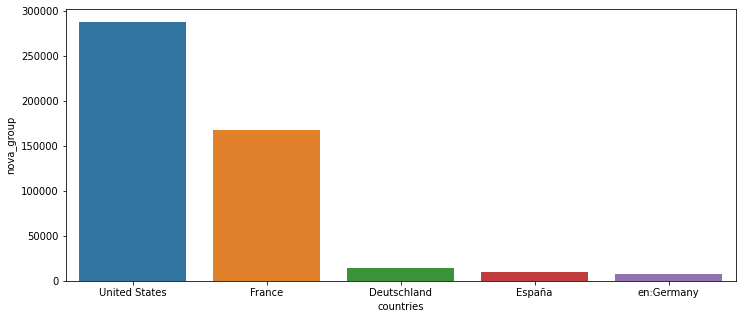

In [ ]:
nova_count_each_country(5)

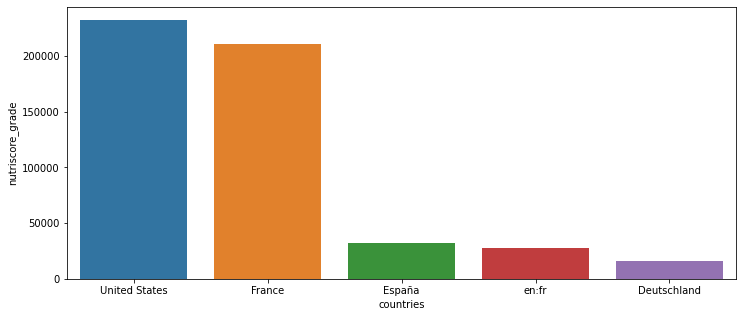

In [ ]:
nutri_count_each_country(5)

**Comment**: United States has the most prominent number of non-missing values in **NOVA_group** and **Nutri_grade** columns for ML pipeline, I will filter out only products from United States origin, also for analyzing their ingredients later

In [ ]:
# only select products from US
data = rawdata[rawdata['countries'].isin(['United States','US','USA'])]
data.loc[data.countries=="US","countries"] = "United States"
data.loc[data.countries=="USA","countries"] = "United States"

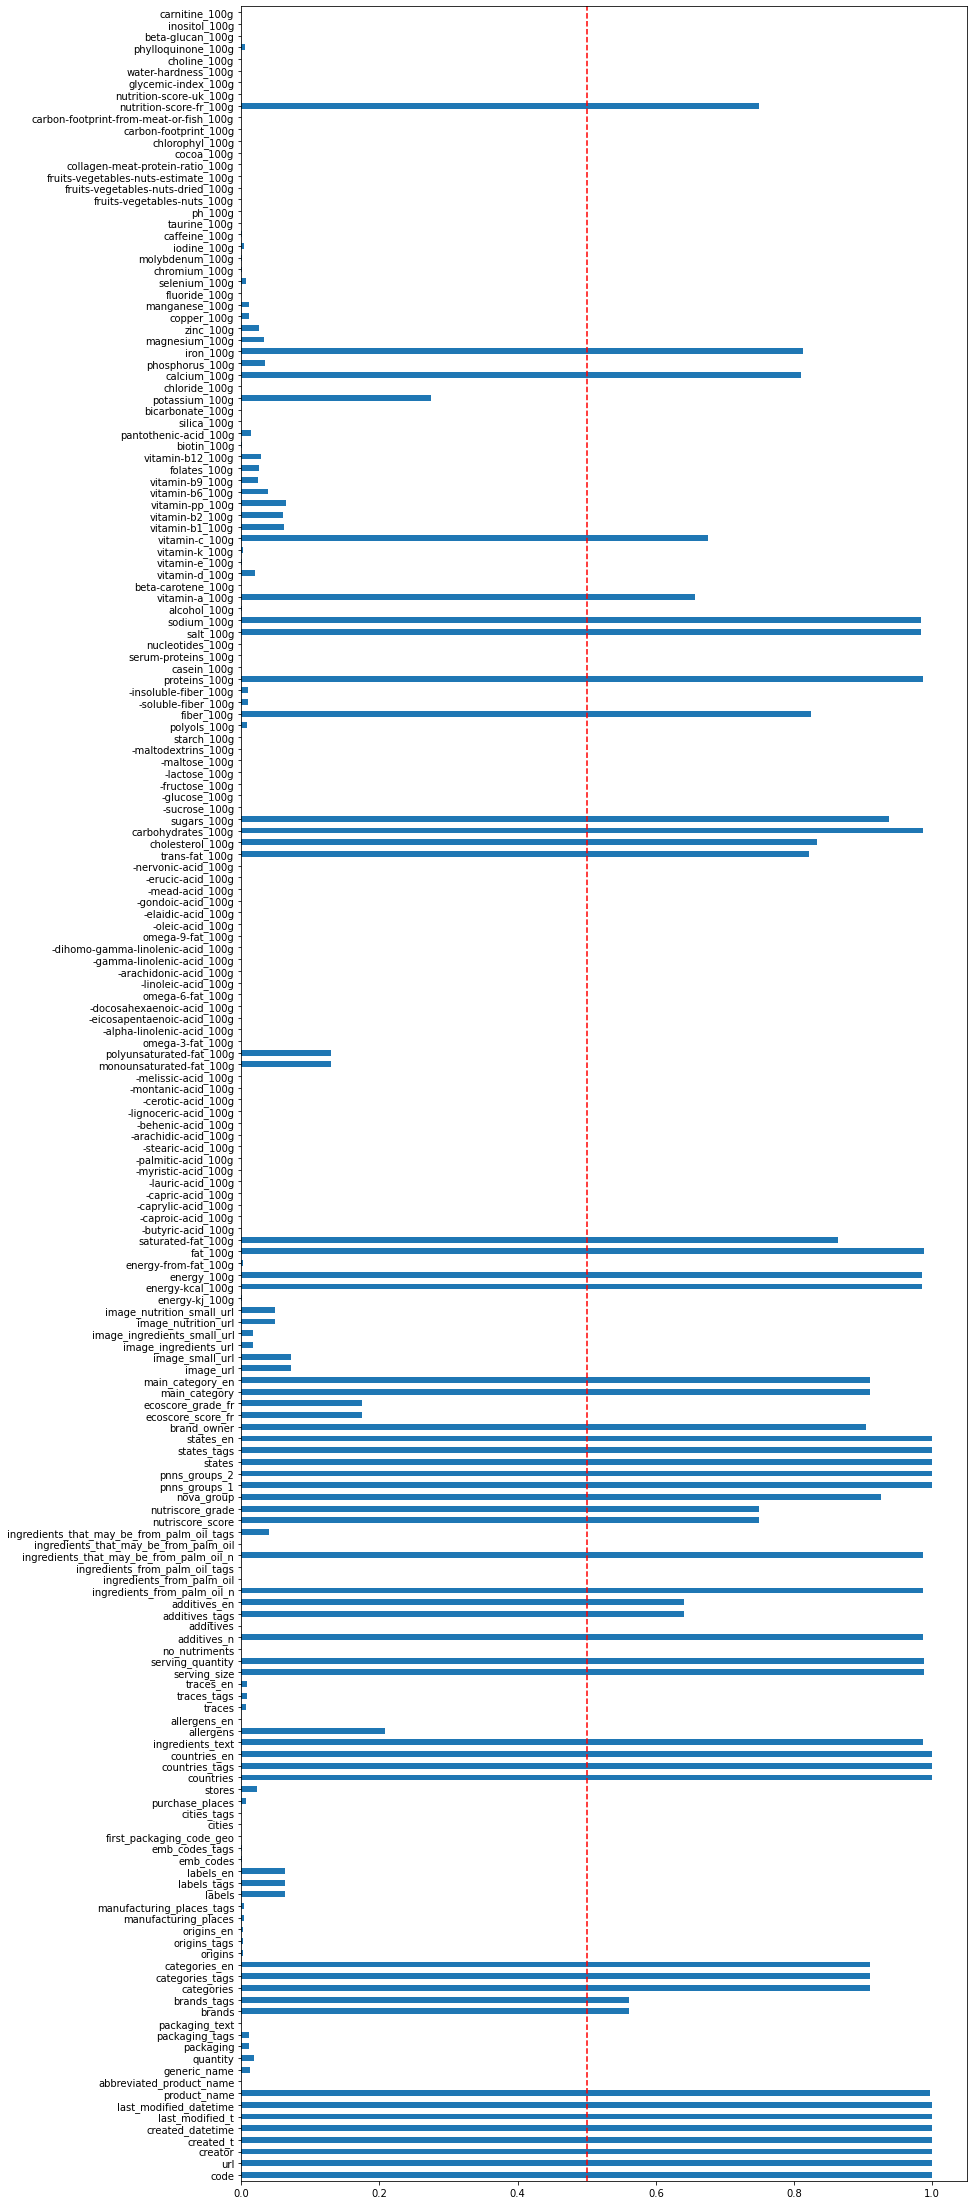

In [ ]:
plt.figure(figsize=(13, 40))
data.notnull().mean(axis=0).plot(kind='barh')
plt.axvline(x=0.5, linestyle='--', color='red')
plt.show()

##**II. Preprocessing the Data**

#### Filtering columns and duplications

Any duplications in the data will be removed

In [ ]:
data = data[~data['code'].duplicated()]
data = data
dup = data.duplicated().sum()
print(f"There's {dup} duplication(s) in the data")

There's 0 duplication(s) in the data


Now only the features that are common in a Nutrition Fact of a food package are selected. Some columns are renamed for better understanding

In [ ]:
cols_to_keep = ["product_name","url","ingredients_text","main_category_en","labels_en","countries_en",
                "nutriscore_score","nutriscore_grade", "nova_group",
                "cholesterol_100g","fat_100g","sodium_100g", "sugars_100g","carbohydrates_100g",
                "proteins_100g", "saturated-fat_100g", "fiber_100g","trans-fat_100g",
                "energy-kcal_100g",
                "additives_en"]

# filter out data with only columns to keep                
data = data[cols_to_keep]

data = data.rename(columns={"ingredients_text":"Ingredients", "product_name":"Name",
                            "main_category_en":"Category",
                            "labels_en":"Label", 'countries_en':"Countries",
                            "nutriscore_score":"nutri_score",
                            "nutriscore_grade": "nutri_grade",
                            "nova_group": "nova_grade",
                            "cholesterol_100g":"Cholesterol",
                            "trans-fat_100g":"Trans fat",
                            "fiber_100g": "Fiber",
                            "fat_100g":"Fat",
                            "saturated-fat_100g":"Saturated fat",
                            "carbohydrates_100g":"Carbohydrates",
                            "proteins_100g":"Protein",
                            "sodium_100g":"Sodium",
                            "sugars_100g":"Sugars",
                            "energy-kcal_100g": "Energy_kcal",
                            "additives_en": "additives",
                            })

In [ ]:
data.head(3)

,product_name,url,nutri_grade,nutri_score,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Energy_kcal,additives
59,Banana Chips Sweetened (Whole),http://world-en.openfoodfacts.org/product/0000000004530/banana-chips-sweetened-whole,NaN,NaN,4.0,0.018,28.57,0.000000,14.29,64.29,3.57,28.57,3.6,536.0,NaN
60,Peanuts,http://world-en.openfoodfacts.org/product/0000000004559/peanuts-torn-glasser,NaN,NaN,NaN,0.000,17.86,0.254000,17.86,60.71,17.86,0.00,7.1,464.0,"E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E503 - Ammonium carbonates,E503ii - Ammonium hydrogen carbonate"
119,Organic Salted Nut Mix,http://world-en.openfoodfacts.org/product/0000000016087/organic-salted-nut-mix-grizzlies,NaN,NaN,NaN,NaN,57.14,0.489712,3.57,17.86,17.86,5.36,7.1,607.0,NaN


### Handling missing values

####Categorical features

Check the missing values count of each column 

In [ ]:
print(f"Missing values in each column:")
print(data.isna().sum())
print('\n',f"Data consists of total {len(data)} products")

Missing values in each column:
Name                889
url                   0
Ingredients        4208
Category          28045
Label            290936
Countries             0
nutri_score       77934
nutri_grade       77934
nova_grade        22767
Cholesterol       51511
Fat                3707
Sodium             5136
Sugars            19402
Carbohydrates      4040
Protein            4138
Saturated fat     42230
Fiber             54547
Trans fat         55363
Energy_kcal        4400
additives        111313
dtype: int64

 Data consists of total 310345 products


Product_name has some missing values, for which will be filled in "Unknown"

In [ ]:
# fill 'Unknown' for missing values in Name and Label
data['Name'] = data['Name'].fillna('Unknown')
data["Label"] = data["Label"].fillna("Unknown")
data["Countries"] = data['Countries'].fillna("Unknown")
# Check again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310345 entries, 59 to 1977165
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           310345 non-null  object 
 1   url            310345 non-null  object 
 2   Ingredients    306137 non-null  object 
 3   Category       282300 non-null  object 
 4   Label          310345 non-null  object 
 5   Countries      310345 non-null  object 
 6   nutri_score    232411 non-null  float64
 7   nutri_grade    232411 non-null  object 
 8   nova_grade     287578 non-null  float64
 9   Cholesterol    258834 non-null  float64
 10  Fat            306638 non-null  float64
 11  Sodium         305209 non-null  float64
 12  Sugars         290943 non-null  float64
 13  Carbohydrates  306305 non-null  float64
 14  Protein        306207 non-null  float64
 15  Saturated fat  268115 non-null  float64
 16  Fiber          255798 non-null  float64
 17  Trans fat      254982 non-n

In [ ]:
# 1 - has additives / 0 - no additives
def check_additives(row):
  if pd.isna(row):
    return 0
  else:
    return len(row.split(','))

In [ ]:
data['Additives_count'] = data['additives'].apply(check_additives)
data["additives"] = data['additives'].fillna("Unknown")
data.head(2)

,Name,url,Ingredients,Category,Label,Countries,nutri_score,nutri_grade,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal,additives,Additives_count
59,Banana Chips Sweetened (Whole),http://world-en.openfoodfacts.org/product/0000000004530/banana-chips-sweetened-whole,"Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.",NaN,Unknown,United States,NaN,NaN,4.0,0.018,28.57,0.000,14.29,64.29,3.57,28.57,3.6,0.0,536.0,Unknown,0
60,Peanuts,http://world-en.openfoodfacts.org/product/0000000004559/peanuts-torn-glasser,"Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.",NaN,Unknown,United States,NaN,NaN,NaN,0.000,17.86,0.254,17.86,60.71,17.86,0.00,7.1,0.0,464.0,"E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E503 - Ammonium carbonates,E503ii - Ammonium hydrogen carbonate",4


####Numerical features

###Filling in missing values for Recommendation

Select products with missing Nova and Nutril labels to fill in using ML models that I will be building later. The purpose of this approach is to increase the number of products available for recommending to users

In [ ]:
m = data[(data.Category.notna()) & (data.Label.notna()) & (data.Ingredients.notna()) & (data.Cholesterol.notna()) & (data.Sodium.notna()) & (data.Sugars.notna()) &(data["Trans fat"].notna()) & (data.Fat.notna()) & (data.Carbohydrates.notna()) & (data.Protein.notna()) & (data["Saturated fat"].notna()) & (data.Fiber.notna())  & (data.Energy_kcal.notna())]
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220396 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             220396 non-null  object 
 1   url              220396 non-null  object 
 2   Ingredients      220396 non-null  object 
 3   Category         220396 non-null  object 
 4   Label            220396 non-null  object 
 5   Countries        220396 non-null  object 
 6   nutri_score      215733 non-null  float64
 7   nutri_grade      215733 non-null  object 
 8   nova_grade       214468 non-null  float64
 9   Cholesterol      220396 non-null  float64
 10  Fat              220396 non-null  float64
 11  Sodium           220396 non-null  float64
 12  Sugars           220396 non-null  float64
 13  Carbohydrates    220396 non-null  float64
 14  Protein          220396 non-null  float64
 15  Saturated fat    220396 non-null  float64
 16  Fiber            220396 non-null  f

This subset of data will be used only for Recommendation system

#####Drop missing values

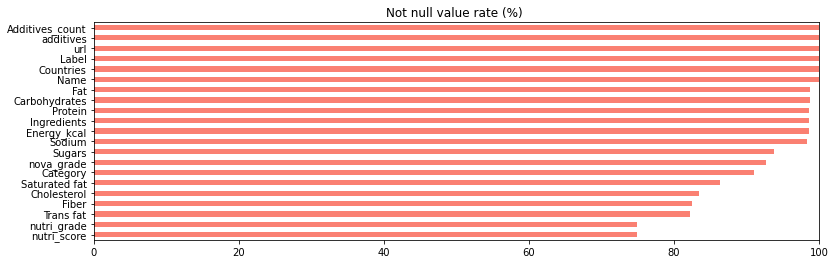

In [ ]:
plt.figure(figsize=(13,4))
(data.notnull().mean(axis=0)*100).sort_values().plot.barh(color ="salmon")
plt.xlim(xmax=100)
plt.title("Not null value rate (%) ")
plt.show()

**Comments:** Some nutrient columns have around 10-25% missing values. Due to the nature of nutrition values in food products, Imputation using Mean/median is not very appropriate, therefore all remaining missing values will be dropped


In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209958 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             209958 non-null  object 
 1   url              209958 non-null  object 
 2   Ingredients      209958 non-null  object 
 3   Category         209958 non-null  object 
 4   Label            209958 non-null  object 
 5   Countries        209958 non-null  object 
 6   nutri_score      209958 non-null  float64
 7   nutri_grade      209958 non-null  object 
 8   nova_grade       209958 non-null  float64
 9   Cholesterol      209958 non-null  float64
 10  Fat              209958 non-null  float64
 11  Sodium           209958 non-null  float64
 12  Sugars           209958 non-null  float64
 13  Carbohydrates    209958 non-null  float64
 14  Protein          209958 non-null  float64
 15  Saturated fat    209958 non-null  float64
 16  Fiber            209958 non-null  f

### Outliers Treatment

In [ ]:
tmp = data.drop(columns=["Name","url","Ingredients","Category","Label","Countries","additives","Additives_count","nova_grade","nutri_grade","nutri_score"])

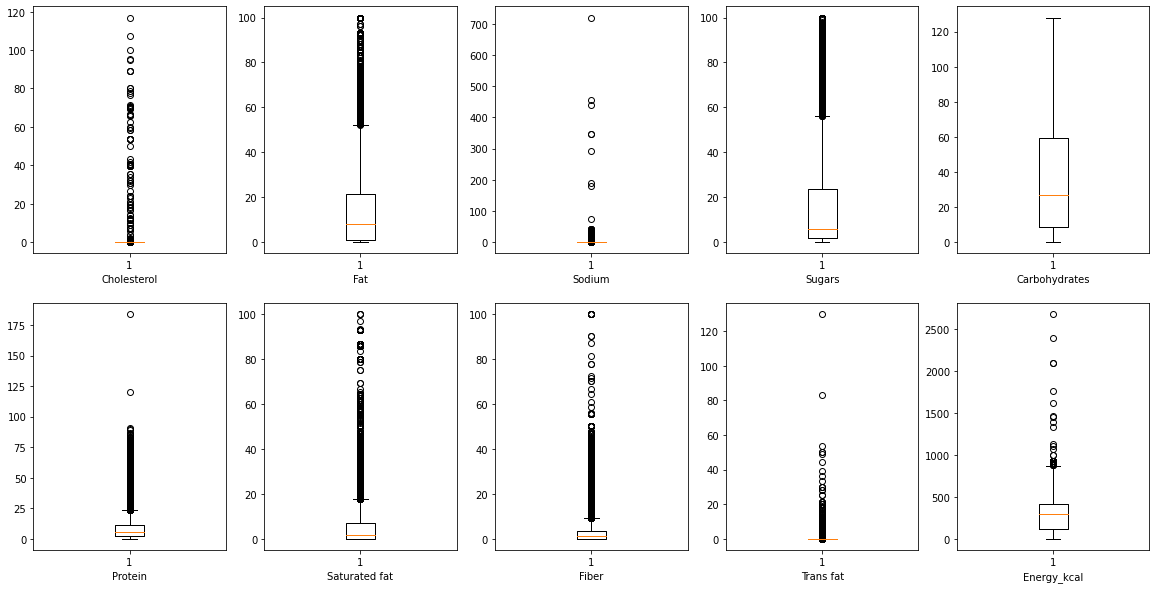

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))
for count, item in enumerate(ax.reshape(-1)):
  item.boxplot(tmp[tmp.columns[count]])

for i in range(2):
  for j in range(5):
    if i == 0:
      ax[i][j].set_xlabel(tmp.columns[j])
    else:
      ax[i][j].set_xlabel(tmp.columns[j+5])

plt.show()

In [ ]:
data.describe()

,nutri_score,nova_grade,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal,Additives_count
count,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000,209958.000000
mean,9.263724,3.430248,0.035975,13.323059,0.496505,14.988734,34.440099,7.973071,4.713527,2.674042,0.034629,285.081161,3.326646
std,9.081380,0.957082,1.063703,15.216983,2.856438,18.989295,27.643219,8.285883,6.708760,4.102146,0.626976,176.706587,4.300508
min,-14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,0.000000,0.910000,0.062000,1.690000,8.770000,2.380000,0.000000,0.000000,0.000000,115.000000,0.000000
50%,11.000000,4.000000,0.000000,8.240000,0.296000,5.710000,26.920000,5.640000,1.810000,1.400000,0.000000,292.000000,2.000000
75%,16.000000,4.000000,0.022000,21.430000,0.567000,23.530000,59.380000,10.830000,7.140000,3.600000,0.000000,417.000000,5.000000
max,40.000000,4.000000,116.915000,100.000000,719.666328,100.000000,128.000000,184.000000,100.000000,100.000000,130.000000,2674.000000,42.000000


Filter out outliers

In [ ]:
# data = data[data["Fat"]<50]
# data = data[data["Cholesterol"]<10]
# data = data[(data["Sodium"]<50)]
# data = data[(data["Sugars"]<60)]
# data = data[(data["Saturated fat"]<30)]
# data = data[(data["Trans fat"]<20)]
# data = data[(data["Fiber"]<10)]
# data = data[(data["Energy_kcal"]<1000)]
# data = data[data.Protein<30]
# len(data)

In [ ]:
# def removeOutliers(data):
#     for column in data:
#         q = data[column].quantile(0.99)
#         data=data[data[column] < q]
#     return data

In [ ]:
q_fat = data.Fat.quantile(0.99)
data = data[data["Fat"]<q_fat]
q_chol = data.Cholesterol.quantile(0.99)
data = data[data["Cholesterol"]<q_chol]
q_sod = data.Sodium.quantile(0.99)
data = data[(data["Sodium"]<q_sod)]
q_sug = data.Sugars.quantile(0.99)
data = data[(data["Sugars"]<q_sug)]
q_sat = data["Saturated fat"].quantile(0.99)
data = data[(data["Saturated fat"]< q_sat)]
q_trans = data["Trans fat"].quantile(0.99)
data = data[(data["Trans fat"]<q_trans)]
q_fib = data["Fiber"].quantile(0.99)
data = data[(data["Fiber"]<q_fib)]
q_ene = data.Energy_kcal.quantile(0.99)
data = data[(data["Energy_kcal"]<q_ene)]
q_pro = data["Protein"].quantile(0.99)
data = data[data.Protein<q_pro]

In [ ]:
data.iloc[:,9:19].describe()

,Cholesterol,Fat,Sodium,Sugars,Carbohydrates,Protein,Saturated fat,Fiber,Trans fat,Energy_kcal
count,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000,190804.000000
mean,0.016041,12.004346,0.380707,14.446214,34.280551,7.400758,4.281046,2.379596,0.002621,270.823775
std,0.027430,12.828051,0.402094,17.562855,27.248067,6.994074,5.618543,3.028119,0.030672,168.061100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.890000,0.064000,1.770000,8.800000,2.420000,0.000000,0.000000,0.000000,106.000000
50%,0.000000,7.550000,0.297000,5.880000,26.870000,5.405405,1.790000,1.400000,0.000000,275.000000
75%,0.021000,20.000000,0.550000,23.330000,59.150000,10.530000,6.670000,3.600000,0.000000,400.000000
max,0.126000,64.285714,3.323000,74.800000,100.000000,35.709998,24.730000,18.100000,0.580000,606.060606


###Categorization & Labeling

####Categorize the products

The Category columns contains a lot of overlapping information such that some products that should have belonged to 1 category were categorized into different ones with similar categories names. I will re-categorize the products into some most common categories:
- Plant-protein/Plant-based-foods
- Meat
- Seafood
- Eggs
- Dairy
- Grain
- Legumes
- Vegetables
- Fruits
etc.

In [ ]:
data.loc[(data.Name.str.contains(r"plant-based|vegetarian|meatless|tofu|vegetarian sausages", flags=re.IGNORECASE, regex=True)) & (data.Category.str.contains(r"Meat", flags=re.IGNORECASE, regex=True)), "Category"] = "Plant-protein"
data.loc[data.Name.str.contains(r"Vegan egg", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"(plant-based foods|frozen foods|frozen vegetables|frozen blueberries)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(fruits and vegetables based foods|fruits based foods)", regex=True), "Category"] = "plant-based-foods"
data.loc[data.Category.str.contains(r"(coconut milk|Soy milks|Plant milks|Almond milks|Soymilks|Cereal milks|Rice milks|Vanilla soy milks|Almon milk yogurts)", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
data.loc[data.Category.str.contains(r"meat|turkey|chicken|lamb|breast|beef|poultry|lobster|pork|bacon|ham", flags=re.IGNORECASE, regex=True), "Category"] = "Meat"
data.loc[data.Category.str.contains(r"(seaf|fish)", flags=re.IGNORECASE, regex=True), "Category"] = "Seafood"
data.loc[(data.Category.str.contains(r"(Plant milks)", flags=re.IGNORECASE, regex=True)), "Label"] = "Vegan"
data.loc[data.Name.str.contains(r"(cheese|parmesan|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(dairy|milk|cheese|yogurt|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Category"] = "Dairy"
data.loc[data.Category.str.contains(r"eggs", flags=re.IGNORECASE, regex=True), "Category"] = "Eggs"
data.loc[data.Category.str.contains(r"grain|rices|oats|chia|cereal", flags=re.IGNORECASE, regex=True), "Category"] = "Grains"
data.loc[data.Category.str.contains(r"\Wnuts|Chestnuts|walnuts|peanuts|hazelnuts|cashews|beans|peas|edamame|quinoa", flags=re.IGNORECASE, regex=True), "Category"] = "Nuts"
data.loc[data.Category.str.contains(r"Nuts", regex=True), "Category"] = "Legumes"
# data.loc[data.Category.str.contains(r"vegetables|salads|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Category.str.contains(r"vegetables|vegetable-mixes|vegetarian", flags=re.IGNORECASE , regex=True), "Category"] = "Vegetables"
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.str.contains(r"(fruits|apples|plums|oranges)", flags=re.IGNORECASE , regex=True), "Category"] = "Fruits"
data.loc[data.Category=="Pizzas", "Category"]="Meals"
data.loc[data.Category=="Chocolate candies", "Category"]="Snacks"
data.loc[data.Category.str.contains(r"chocolate candies|Biscuits", regex=True), "Category"] = "Snacks"
data.loc[data.Category.str.contains(r"frozen desserts|cakes",flags=re.IGNORECASE , regex=True), "Category"] = "Desserts"
data.loc[data.Category.str.contains(r"snacks|salted-snacks", regex=True), "Category"] = "Snacks"
data.loc[data.Category=="Sausages","Category"]="Meat"
data.loc[data.Category=="Canned soups","Category"]="Meals"
data.loc[data.Category=="Soups","Category"]="Meals"
data.loc[data.Category=="Tomatoes","Category"]="Vegetables"
data.loc[data.Category=="Sandwiches","Category"]="Breads"
data.loc[data.Category=="Pasta dishes","Category"]="Pasta"

##IV. Separate data for ML pipelines

For each ML pipeline, the features representing the nutrients are chosen with the corresponding label for prediction and classification

In [ ]:
cols_nova = ['Cholesterol','Fat','Fiber','Saturated fat',"Trans fat",'Carbohydrates','Protein','Sodium','Sugars','Energy_kcal','Additives_count','nova_grade']
df_nova = data[cols_nova]

cols_nutri = ['Cholesterol','Fat','Fiber','Saturated fat',"Trans fat",'Carbohydrates','Protein','Sodium','Sugars','Energy_kcal','Additives_count','nutri_score','nutri_grade',]
df_nutri = data[cols_nutri]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190804 entries, 286 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Name             190804 non-null  object 
 1   url              190804 non-null  object 
 2   Ingredients      190804 non-null  object 
 3   Category         190804 non-null  object 
 4   Label            190804 non-null  object 
 5   Countries        190804 non-null  object 
 6   nutri_score      190804 non-null  float64
 7   nutri_grade      190804 non-null  object 
 8   nova_grade       190804 non-null  float64
 9   Cholesterol      190804 non-null  float64
 10  Fat              190804 non-null  float64
 11  Sodium           190804 non-null  float64
 12  Sugars           190804 non-null  float64
 13  Carbohydrates    190804 non-null  float64
 14  Protein          190804 non-null  float64
 15  Saturated fat    190804 non-null  float64
 16  Fiber            190804 non-null  f

In [ ]:
corr_matrix = df_nova.corr()
corr_matrix.style.background_gradient(cmap='Reds')

,Cholesterol,Fat,Fiber,Saturated fat,Trans fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives_count,nova_grade
Cholesterol,1.000000,0.295678,-0.312902,0.499389,0.063594,-0.330894,0.497980,0.211183,-0.152646,0.079125,0.061582,0.141108
Fat,0.295678,1.000000,0.220209,0.731082,0.013076,0.068729,0.405960,0.191609,0.094815,0.765382,0.073379,0.178526
Fiber,-0.312902,0.220209,1.000000,-0.023195,-0.026213,0.364401,0.212258,-0.049955,0.038484,0.389281,-0.131651,-0.152466
Saturated fat,0.499389,0.731082,-0.023195,1.000000,0.032915,0.036937,0.328711,0.087686,0.235988,0.563795,0.137442,0.227256
Trans fat,0.063594,0.013076,-0.026213,0.032915,1.000000,-0.022133,-0.001689,-0.003852,-0.013012,-0.004671,0.043574,0.036795
Carbohydrates,-0.330894,0.068729,0.364401,0.036937,-0.022133,1.000000,-0.101538,-0.061007,0.614363,0.664620,0.240231,0.106688
Protein,0.497980,0.405960,0.212258,0.328711,-0.001689,-0.101538,1.000000,0.269901,-0.272671,0.360272,-0.116925,-0.002507
Sodium,0.211183,0.191609,-0.049955,0.087686,-0.003852,-0.061007,0.269901,1.000000,-0.263671,0.146440,0.047099,0.260610
Sugars,-0.152646,0.094815,0.038484,0.235988,-0.013012,0.614363,-0.272671,-0.263671,1.000000,0.406416,0.281540,0.220135
Energy_kcal,0.079125,0.765382,0.389281,0.563795,-0.004671,0.664620,0.360272,0.146440,0.406416,1.000000,0.188220,0.190976


**Comment:** Correlation plot suggests that Fiber and Protein might be negatively correlated to Nova-grade whereas other features have positive correlation.

In addition, Additives seems to explains the most the variation in Nova-grade

In [ ]:
corr_matrix = df_nutri.corr()
corr_matrix.style.background_gradient(cmap='Reds')

,Cholesterol,Fat,Fiber,Saturated fat,Trans fat,Carbohydrates,Protein,Sodium,Sugars,Energy_kcal,Additives_count,nutri_score
Cholesterol,1.000000,0.295678,-0.312902,0.499389,0.063594,-0.330894,0.497980,0.211183,-0.152646,0.079125,0.061582,0.276612
Fat,0.295678,1.000000,0.220209,0.731082,0.013076,0.068729,0.405960,0.191609,0.094815,0.765382,0.073379,0.596579
Fiber,-0.312902,0.220209,1.000000,-0.023195,-0.026213,0.364401,0.212258,-0.049955,0.038484,0.389281,-0.131651,-0.135218
Saturated fat,0.499389,0.731082,-0.023195,1.000000,0.032915,0.036937,0.328711,0.087686,0.235988,0.563795,0.137442,0.680200
Trans fat,0.063594,0.013076,-0.026213,0.032915,1.000000,-0.022133,-0.001689,-0.003852,-0.013012,-0.004671,0.043574,0.027921
Carbohydrates,-0.330894,0.068729,0.364401,0.036937,-0.022133,1.000000,-0.101538,-0.061007,0.614363,0.664620,0.240231,0.349983
Protein,0.497980,0.405960,0.212258,0.328711,-0.001689,-0.101538,1.000000,0.269901,-0.272671,0.360272,-0.116925,0.089948
Sodium,0.211183,0.191609,-0.049955,0.087686,-0.003852,-0.061007,0.269901,1.000000,-0.263671,0.146440,0.047099,0.332508
Sugars,-0.152646,0.094815,0.038484,0.235988,-0.013012,0.614363,-0.272671,-0.263671,1.000000,0.406416,0.281540,0.531410
Energy_kcal,0.079125,0.765382,0.389281,0.563795,-0.004671,0.664620,0.360272,0.146440,0.406416,1.000000,0.188220,0.645338


**Comment:** Correlation plot suggests that total Fat, Saturated fat, Sugars, and Energy are most correlated with Nutri-score. While most features have positive correlations with the label, it's not surprising that Fiber is negatively correlated, or the more fiber content the more nutritious a food product.

 However, Correaltion coefficient only measures linear colleration and might completely miss out on nonlinear relationship.

##V. Export

In [ ]:
# df_nutri.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nutri.csv", index=False)  #ML Model
# df_nova.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nova.csv", index=False) 
# data.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/eda.csv", index=False) #For EDA.ipynb
m.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/recommendation_df.csv", index=False)  # Recommendation

#EDA

##Relationship between Nutrients and the Quality of Foods

In [ ]:
def boxplot_multi_nova(feature):
  """
  Draw a boxplot for a given feature
  """
  sns.boxplot(data=df_nova, x='nova_grade', y=feature)
  plt.ylabel(feature, fontsize=16)
  # plt.ylim(bottom=0)
  plt.xlabel("")

order_nutri = pd.value_counts(df_nutri['nutri_grade']).sort_index().index

def boxplot_multi_nutri(feature):
  """
  Draw a boxplot for a given feature
  """
  sns.boxplot(data=df_nutri, x='nutri_grade', y=feature, order=order_nutri)
  plt.xlabel("")
  plt.ylabel(feature, fontsize=16)

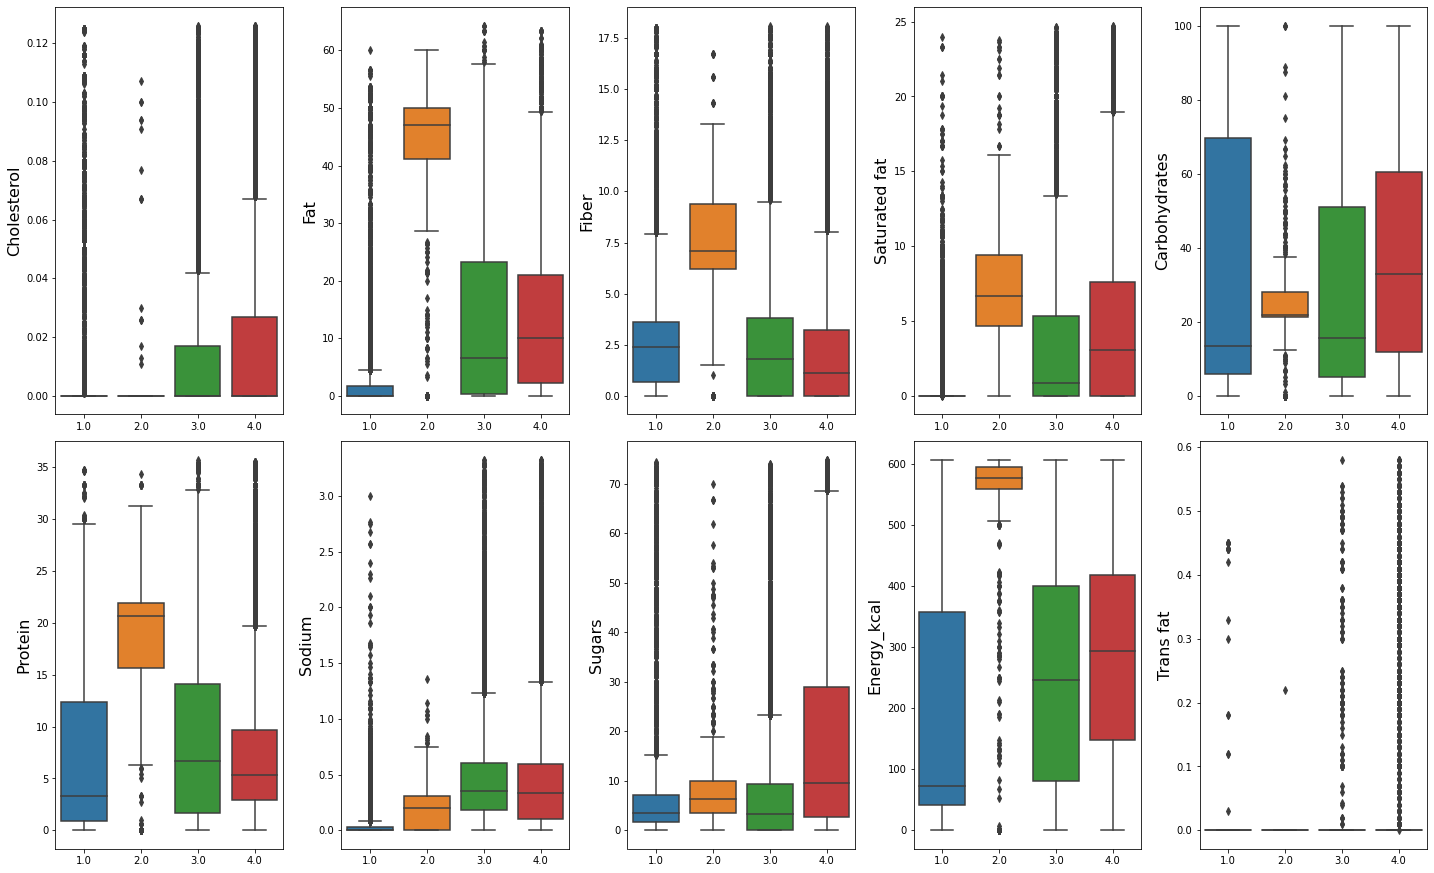

In [ ]:
#Distribution of Nutrient for each Nova-grade

plt.figure(figsize=(20,18))
# plt.title("How do Nutrients distribute for each Nova-grade?")

plt.subplot(351)
boxplot_multi_nova('Cholesterol')
# plt.ylim(top=0.2, bottom=-0.01)
# sns.boxplot(data=df_nova, x='nova_grade', y='Cholesterol', showfliers=False)
# plt.ylabel('Cholesterol', fontsize=16)
# plt.xlabel("")
plt.subplot(352)
boxplot_multi_nova('Fat')
plt.subplot(353)
boxplot_multi_nova('Fiber')
plt.subplot(354)
boxplot_multi_nova('Saturated fat')
plt.subplot(355)
boxplot_multi_nova('Carbohydrates')
plt.subplot(356)
boxplot_multi_nova('Protein')
plt.subplot(357)
boxplot_multi_nova('Sodium')
# plt.ylim(top=10, bottom=-0.5)
# sns.boxplot(data=df_nova, x='nova_grade', y='Sodium', showfliers=False)
# plt.ylabel("Sodium", fontsize=16)
# plt.xlabel("")
plt.subplot(358)
boxplot_multi_nova('Sugars')
plt.subplot(3,5,9)
boxplot_multi_nova('Energy_kcal')
plt.subplot(3,5,10)
boxplot_multi_nova('Trans fat')
# plt.ylim(top=0.25, bottom=-0.01)
# sns.boxplot(data=df_nova, x='nova_grade', y='Trans fat', showfliers=False)
# plt.ylabel("Trans fat", fontsize=16)
# plt.xlabel("")
plt.savefig("nova_boxplot.jpg",dpi=300)
plt.tight_layout(pad=1)
plt.show()

**Comment**:
1. Additives, it's no suprised that the foods with most additives added undergo a lot of processing

2. Sugar and Sodium follow the same logic. This is what you would expect.

3. Fiber, it's interesting that processed foods tend to not have much Fiber content. So there are less risks when choosing high-fiber food

5. Proteins, Finally the proteins do not seem to dicriminate a particular nutritional grade.

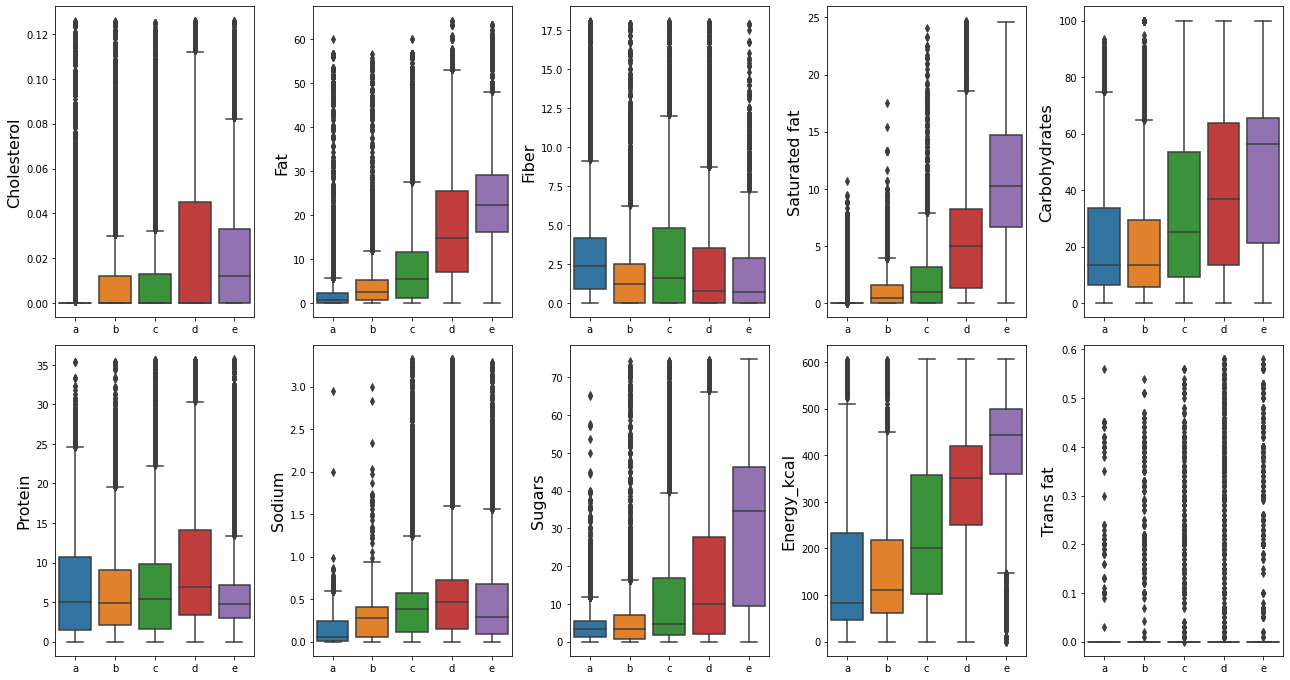

In [ ]:
plt.figure(figsize=(18,14))
plt.subplot(351)
boxplot_multi_nutri('Cholesterol')
# sns.boxplot(data=df_nutri, x='nutri_grade', y='Cholesterol', showfliers=False, order=order_nutri)
# plt.ylabel('Cholesterol', fontsize=12)
plt.subplot(352)
boxplot_multi_nutri('Fat')
plt.subplot(353)
boxplot_multi_nutri('Fiber')
plt.subplot(354)
boxplot_multi_nutri('Saturated fat')
plt.subplot(355)
boxplot_multi_nutri('Carbohydrates')
plt.subplot(356)
boxplot_multi_nutri('Protein')
plt.subplot(357)
boxplot_multi_nutri("Sodium")
# sns.boxplot(data=df_nutri, x='nutri_grade', y='Sodium', showfliers=False, order=order_nutri)
# plt.ylabel('Sodium', fontsize=12)
plt.subplot(358)
boxplot_multi_nutri('Sugars')
plt.subplot(359)
boxplot_multi_nutri('Energy_kcal')
plt.subplot(3,5,10)
boxplot_multi_nutri('Trans fat')

plt.tight_layout(pad=1)
plt.savefig("nutri_boxplot.jpg",dpi=300)
plt.show()

###Nutri & Nova

**Comment:** Before going into details aboout nutrition, let's first have a look at how the Nutri-grade and Nova-grade proportions of the products from OpenFoodFacts are distributed

In [ ]:
rawdata.loc[(rawdata.countries!="United States"), "countries"] = "Others"
notna = rawdata[(rawdata.nova_group.notna()) & (rawdata.nutriscore_grade.notna())]
notna = notna[["countries","nova_group","nutriscore_grade"]]
print(len(notna))
notna.head(2)

467935


,countries,nova_group,nutriscore_grade
72,Others,4.0,a
286,United States,3.0,c


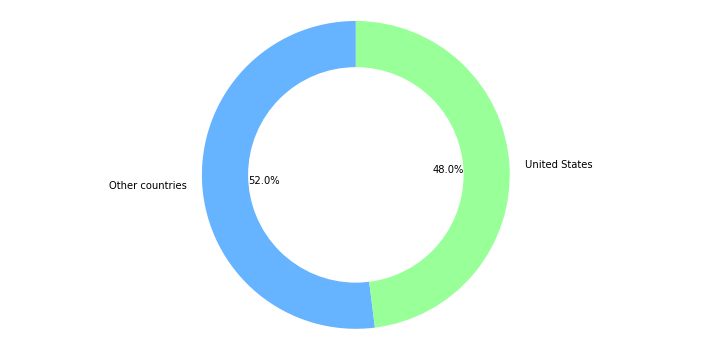

In [ ]:
plt.figure(figsize=(10,5))

ccount = notna.countries.value_counts()
labels = ["Other countries", "United States"]
plt.pie(ccount, colors=['#66b3ff','#99ff99'],labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

**Comments:** Among more than 450K food packages that have been graded, Products from US accounts for half of the products worldwide. Let's dive deeper into how the distritbution of each grading scale is for US compared to Worldwide

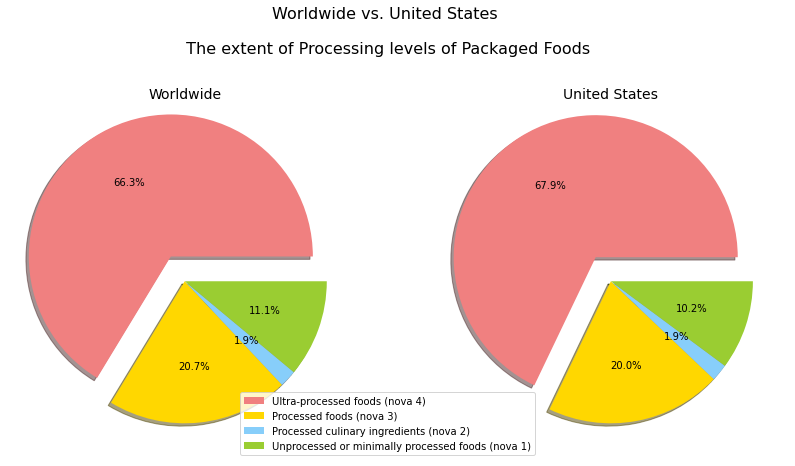

In [ ]:
#NOVA
plt.figure(figsize=(14,8))
plt.suptitle("Worldwide vs. United States\n\n The extent of Processing levels of Packaged Foods", size=16)

# Worldwide
plt.subplot(121)
nova_count = rawdata.nova_group.value_counts(normalize=True).sort_index(ascending=False)
labels_nova = ['Ultra-processed foods (nova 4)','Processed foods (nova 3)','Processed culinary ingredients (nova 2)','Unprocessed or minimally processed foods (nova 1)']
colors_nova = ['lightcoral','gold','lightskyblue','yellowgreen']
explode_nova = (0.2,0,0,0)
plt.pie(nova_count,colors=colors_nova, autopct = '%1.1f%%',counterclock=True, explode = explode_nova, shadow=True)
# plt.legend(labels_nova, loc='lower right')
plt.title('Worldwide', size=14)

# USA
plt.subplot(122)
nova_count = data.nova_group.value_counts(normalize=True).sort_index(ascending=False)

plt.pie(nova_count,colors=colors_nova, autopct = '%1.1f%%',counterclock=True, explode = explode_nova, shadow=True)
plt.title('United States', size=14)

plt.legend(labels_nova,loc = 'center right', bbox_to_anchor=(0.3, 0.1))

plt.show()

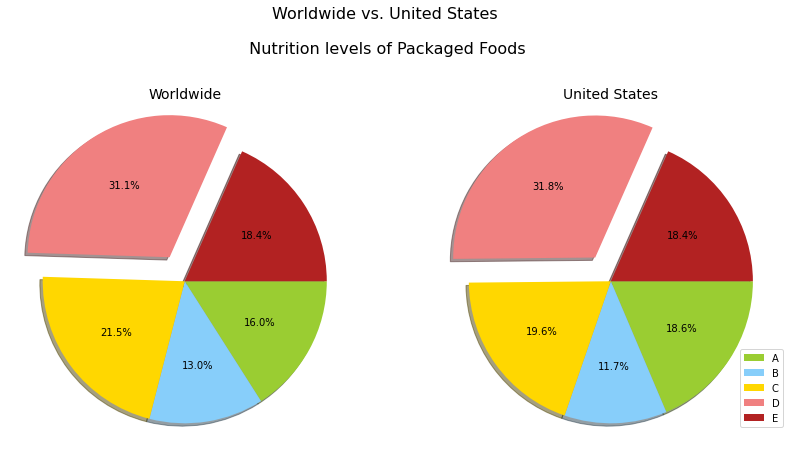

In [ ]:
#Nutri
plt.figure(figsize=(14,8))
plt.suptitle("Worldwide vs. United States\n\n Nutrition levels of Packaged Foods", size=16)

# Worldwide
plt.subplot(121)
nutri_count = rawdata.nutriscore_grade.value_counts(normalize=True).sort_index()
labels_nutri = ["A","B","C","D","E"]
colors_nutri = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_nutri = (0,0,0,0.2,0)

plt.pie(nutri_count,colors=colors_nutri, explode=explode_nutri,counterclock=False, autopct = '%1.1f%%', shadow=True)
plt.title('Worldwide', size=14)

# USA
plt.subplot(122)
nutri_count = data.nutriscore_grade.value_counts(normalize=True).sort_index()

plt.pie(nutri_count,colors=colors_nutri, explode=explode_nutri,counterclock=False, autopct = '%1.1f%%', shadow=True)
plt.title('United States', size=14)

plt.legend(labels_nutri,loc = 'center right', bbox_to_anchor=(1, 0.2))

plt.show()

**Comment**: About 70% of packaged foods from United States are heavily processed.
This number is very consistent with most published reports of fast food in United States. Only a very smaller portion of food is unprocessed or minimally procssed.

Regarding Nutri-grade, In nearly 2 million food products in OFF database, nearly half (49.5%) of foods are given Nutri-grade of D or below, meaning they are regarded as very unhealthy and might not contain any nutrition at all


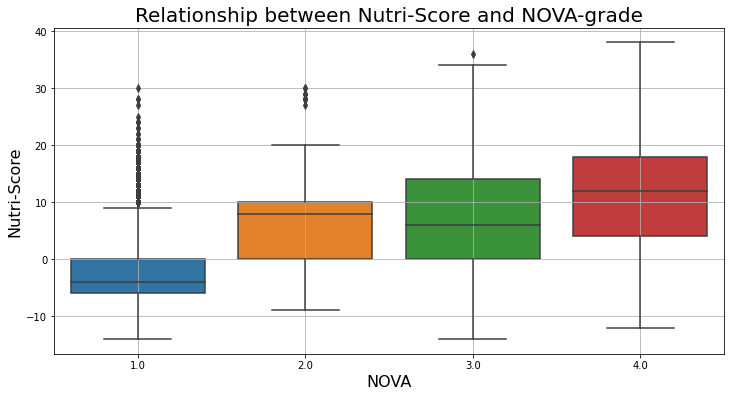

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data, x="nova_grade", y="nutri_score")
plt.xlabel("NOVA", size=16)
plt.ylabel("Nutri-Score", size=16)
plt.title("Relationship between Nutri-Score and NOVA-grade", size=20)
plt.grid()
plt.savefig("nutri_nova.jpg",dpi=300)
plt.show()

##Vegan vs. Meat

In [ ]:
df = data.copy()

####Category-wise

Which **Categories** are the most common among the products?

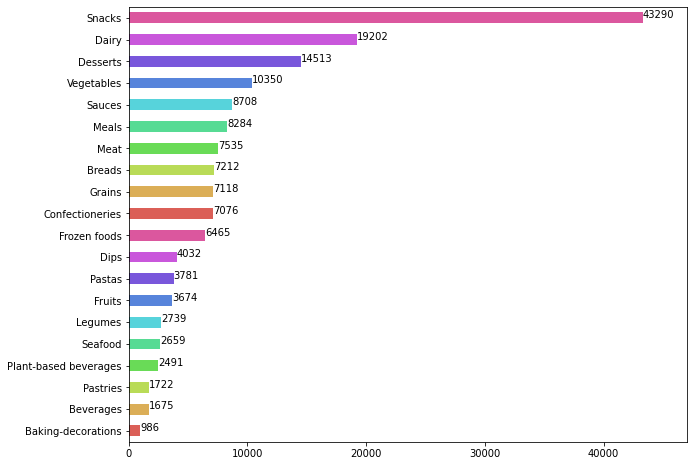

In [ ]:
# Top 20 categories
plt.figure(figsize=(10,8))
cat_count = data.Category.value_counts()[:20].sort_values()
cplot = cat_count.plot.barh(color = sns.color_palette('hls',10))
for i,v in enumerate(cat_count):
  cplot.text(v,i, str(v))
plt.xlim(right=47000)
plt.show()

Only the most common categories are used for further analysis

In [ ]:
cat = ["Snacks","Dairy","Desserts","Vegetables","Sauces","Meals","Meat","Grains","Breads","Confectioneries","Frozen foods","Pasta","Seafood","Fruits","Beverages","Legumes","Plant-based beverages","Beverages"]
data = data.loc[(data.Category.isin(cat))]
print(data.Category.unique())
print(len(data))

['Breads' 'Snacks' 'Desserts' 'Confectioneries' 'Sauces'
 'Plant-based beverages' 'Beverages' 'Meals' 'Vegetables' 'Grains' 'Dairy'
 'Seafood' 'Frozen foods' 'Pasta' 'Legumes' 'Meat' 'Fruits']
153939


###Is Vegan better?

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    16490
Vegan          842
Name: Label, dtype: int64

Let's separate the products into "Vegan/Non Vegan"

In [ ]:
data.loc[(data.Label.str.contains(r"veg", flags=re.IGNORECASE, regex=True)) & (data.Label != "Non Vegan"), "Label"] = "Vegan"

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Non Vegan    16490
Vegan         1010
Name: Label, dtype: int64

In [ ]:
veg = ["Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein","Plant-based-foods","Plant-based beverages"]
data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"
data.loc[data.Category.isin(veg),"Label"] = "Vegan"

In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Vegan        27358
Non Vegan    16295
Name: Label, dtype: int64

In [ ]:
non_veg = ["Seafood"]
data.loc[data.Category.isin(non_veg),"Label"] = "Non Vegan"

data.loc[data.Name.str.contains(r"eggs") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 
data.loc[(data.Category=="Meat") & (data.Label!="Vegan"), "Label"] = "Non Vegan" 
# data.loc[(data.Category=="Dairy") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"
# data.loc[(data.Category=="Beverages") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"
# data.loc[(data.Category=="Frozen foods") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"

In [ ]:
# veg = ["Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein","Plant-based-foods","Plant-based beverages"]
# non_veg = ["Meat", "Seafood", "Eggs", "Meals", "Beverages",""]

# data.loc[data.Category.isin(veg),"Label"] = "Vegan"

# data.loc[data.Category.isin(non_veg),"Label"] = "Non Vegan"
# data.loc[(data.Category=="Dairy") & (data.Label!= "Vegan"), "Label"] = "Non Vegan"

# data.loc[data.Label.str.contains("Vegetarian"), "Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"Vegan egg", flags=re.IGNORECASE, regex=True),"Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"(cheese|parmesan|cheddar|mozzarella)", flags=re.IGNORECASE, regex=True), "Label"] = "Non Vegan"
# data.loc[(data.Category.str.contains(r"(Plant milks)", flags=re.IGNORECASE, regex=True)), "Label"] = "Vegan"
# data.loc[data.Name.str.contains(r"Romaine lettuce, caesar dressing", flags=re.IGNORECASE, regex=True),"Label"] = "Non Vegan"


In [ ]:
data[data.Label.isin(["Vegan","Non Vegan"])].Label.value_counts()

Vegan        27357
Non Vegan    26310
Name: Label, dtype: int64

In [ ]:
# cat_vm = ["Meat", "Seafood", "Eggs", "Dairy", "Grains", "Legumes", "Fruits", "Vegetables", "Plant-protein"]
# veg_df = df.loc[(df.Category.isin(cat_vm)) | (df.Label.isin(["Vegan"]))]

In [ ]:
veg_df = data[data.Label.isin(["Vegan","Non Vegan"])]
veg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53667 entries, 1209 to 1976960
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             53667 non-null  object 
 1   url              53667 non-null  object 
 2   Ingredients      53667 non-null  object 
 3   Category         53667 non-null  object 
 4   Label            53667 non-null  object 
 5   Countries        53667 non-null  object 
 6   nutri_score      53667 non-null  float64
 7   nutri_grade      53667 non-null  object 
 8   nova_grade       53667 non-null  float64
 9   Cholesterol      53667 non-null  float64
 10  Fat              53667 non-null  float64
 11  Sodium           53667 non-null  float64
 12  Sugars           53667 non-null  float64
 13  Carbohydrates    53667 non-null  float64
 14  Protein          53667 non-null  float64
 15  Saturated fat    53667 non-null  float64
 16  Fiber            53667 non-null  float64
 17  Trans f

In [ ]:
veg_df = veg_df.drop(columns=["url","Ingredients","Countries","nutri_score"])

In [ ]:
veg_df.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/veg_df.csv", index=False)

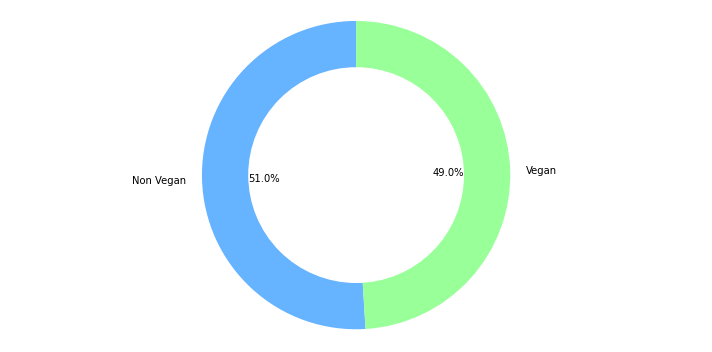

In [ ]:
plt.figure(figsize=(10,5))

lcount = veg_df.Label.value_counts()
labels = ["Non Vegan","Vegan"]
plt.pie(lcount, colors=['#66b3ff','#99ff99'],labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

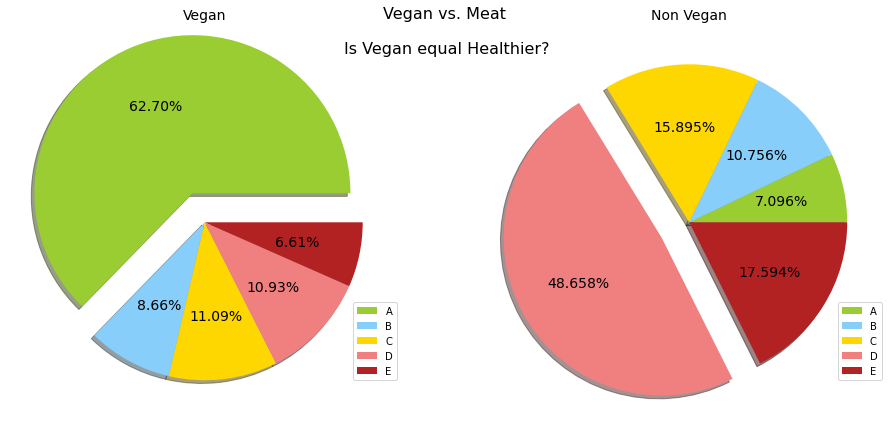

In [ ]:
plt.figure(figsize=(14,6))
plt.suptitle("Vegan vs. Meat \n\nIs Vegan equal Healthier?", size = 16)
# Vegan
plt.subplot(121)
nutri_v = veg_df[veg_df.Label=="Vegan"].nutri_grade.value_counts().sort_index()
labels = ["A","B","C","D","E"]
colors = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_v = (0.2,0,0,0,0)
plt.title('Vegan', size = 14)
plt.pie(nutri_v, colors=colors, autopct = '%1.2f%%', explode=explode_v, counterclock=True, shadow=True, textprops={'fontsize':14})
plt.legend(labels,loc = 'center right', bbox_to_anchor=(1, 0.2))
# Non vegan
plt.subplot(122)
nutri_n = veg_df[veg_df.Label=="Non Vegan"].nutri_grade.value_counts().sort_index()
colors_nv = ['yellowgreen','lightskyblue','gold','lightcoral','firebrick']
explode_n = (0,0,0,0.2,0)
plt.title('Non Vegan', size = 14)
plt.pie(nutri_n, colors=colors_nv, autopct = '%1.3f%%', explode=explode_n, counterclock=True, shadow=True, textprops={'fontsize':14})

plt.legend(labels,loc = 'center right', bbox_to_anchor=(1, 0.2))
plt.tight_layout(pad=1)

plt.show()

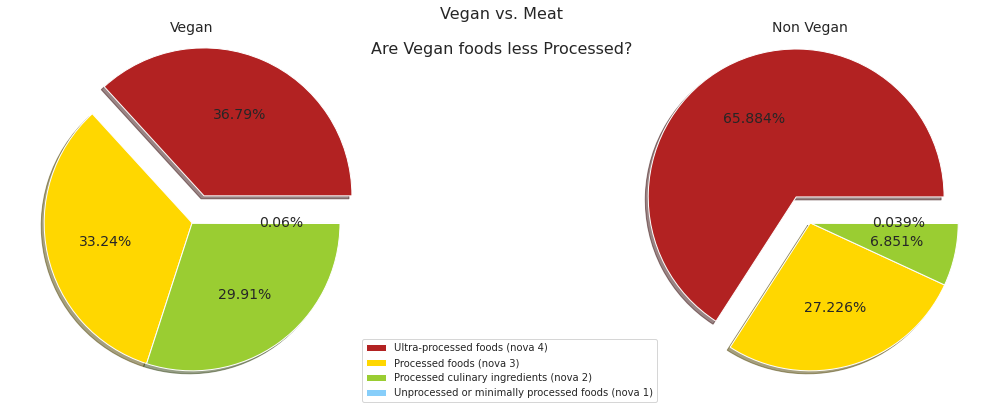

In [ ]:
plt.figure(figsize=(14,6))
plt.suptitle("Vegan vs. Meat\n\nAre Vegan foods less Processed?", size = 16)
# Vegan
plt.subplot(121)
nova_v = veg_df[veg_df.Label=="Vegan"].nova_grade.value_counts()
labels_v = ['Ultra-processed foods (nova 4)','Processed foods (nova 3)','Processed culinary ingredients (nova 2)','Unprocessed or minimally processed foods (nova 1)']
colors_v = ['firebrick','gold','yellowgreen','lightskyblue']
explode_v = (0.2,0,0,0)

plt.title('Vegan', size = 14)
plt.pie(nova_v, colors=colors_v, autopct = '%1.2f%%', explode=explode_v, counterclock=True, shadow=True, textprops={'fontsize':14})
# plt.legend(labels_v,loc = 'center right', bbox_to_anchor=(0.1, 0.1))
#Non vegan
plt.subplot(122)
nova_n = veg_df[veg_df.Label=="Non Vegan"].nova_grade.value_counts()
colors_n = ['firebrick','gold', 'yellowgreen','lightskyblue']
explode_n = (0.2,0,0,0)

plt.title('Non Vegan', size = 14)
plt.pie(nova_n, colors=colors_n, autopct = '%1.3f%%', explode=explode_n, counterclock=True, shadow=True, textprops={'fontsize':14})

plt.legend(labels_v,loc = 'center right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout(pad=1)
plt.savefig("veg_nutri.jpg", dpi=300)

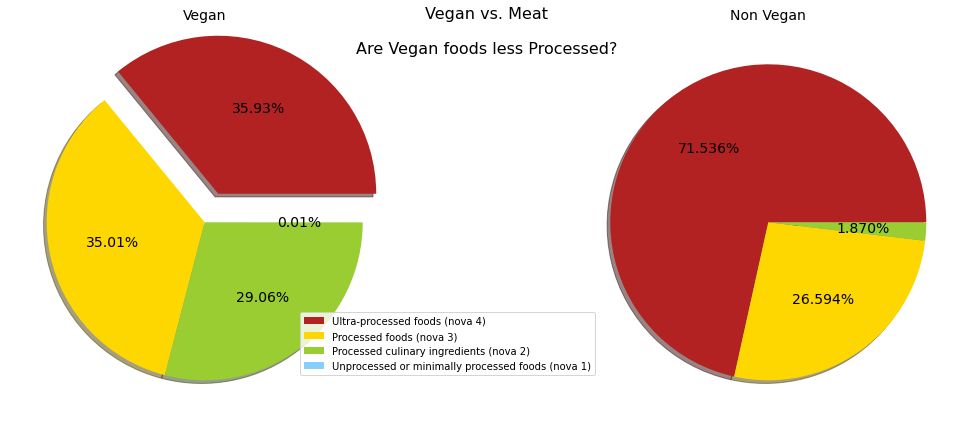

In [ ]:
plt.figure(figsize=(14,6))
plt.suptitle("Vegan vs. Meat\n\nAre Vegan foods less Processed?", size = 16)
# Vegan
plt.subplot(121)
nova_v = veg_df[veg_df.Label=="Vegan"].nova_grade.value_counts()
labels_v = ['Ultra-processed foods (nova 4)','Processed foods (nova 3)','Processed culinary ingredients (nova 2)','Unprocessed or minimally processed foods (nova 1)']
colors_v = ['firebrick','gold','yellowgreen','lightskyblue']
explode_v = (0.2,0,0,0)

plt.title('Vegan', size = 14)
plt.pie(nova_v, colors=colors_v, autopct = '%1.2f%%', explode=explode_v, counterclock=True, shadow=True, textprops={'fontsize':14})
plt.legend(labels_v,loc = 'lower right', bbox_to_anchor=(1.5, 0.1))

#Non vegan
plt.subplot(122)
nova_n = veg_df[veg_df.Label=="Non Vegan"].nova_grade.value_counts()
colors_n = ['firebrick','gold', 'yellowgreen','lightskyblue']
# explode_n = (0.2,0,0,0)

plt.title('Non Vegan', size = 14)
plt.pie(nova_n, colors=colors_n, autopct = '%1.3f%%',  counterclock=True, shadow=True, textprops={'fontsize':14})

# plt.legend(labels_v,loc = 'center right', bbox_to_anchor=(0.1, 0.1))
plt.tight_layout(pad=1)
plt.savefig("veg_nutri.jpg", dpi=300)

###Exploring the Nutrients

####Bad Nutrients

Top **Sodium-rich** Foods

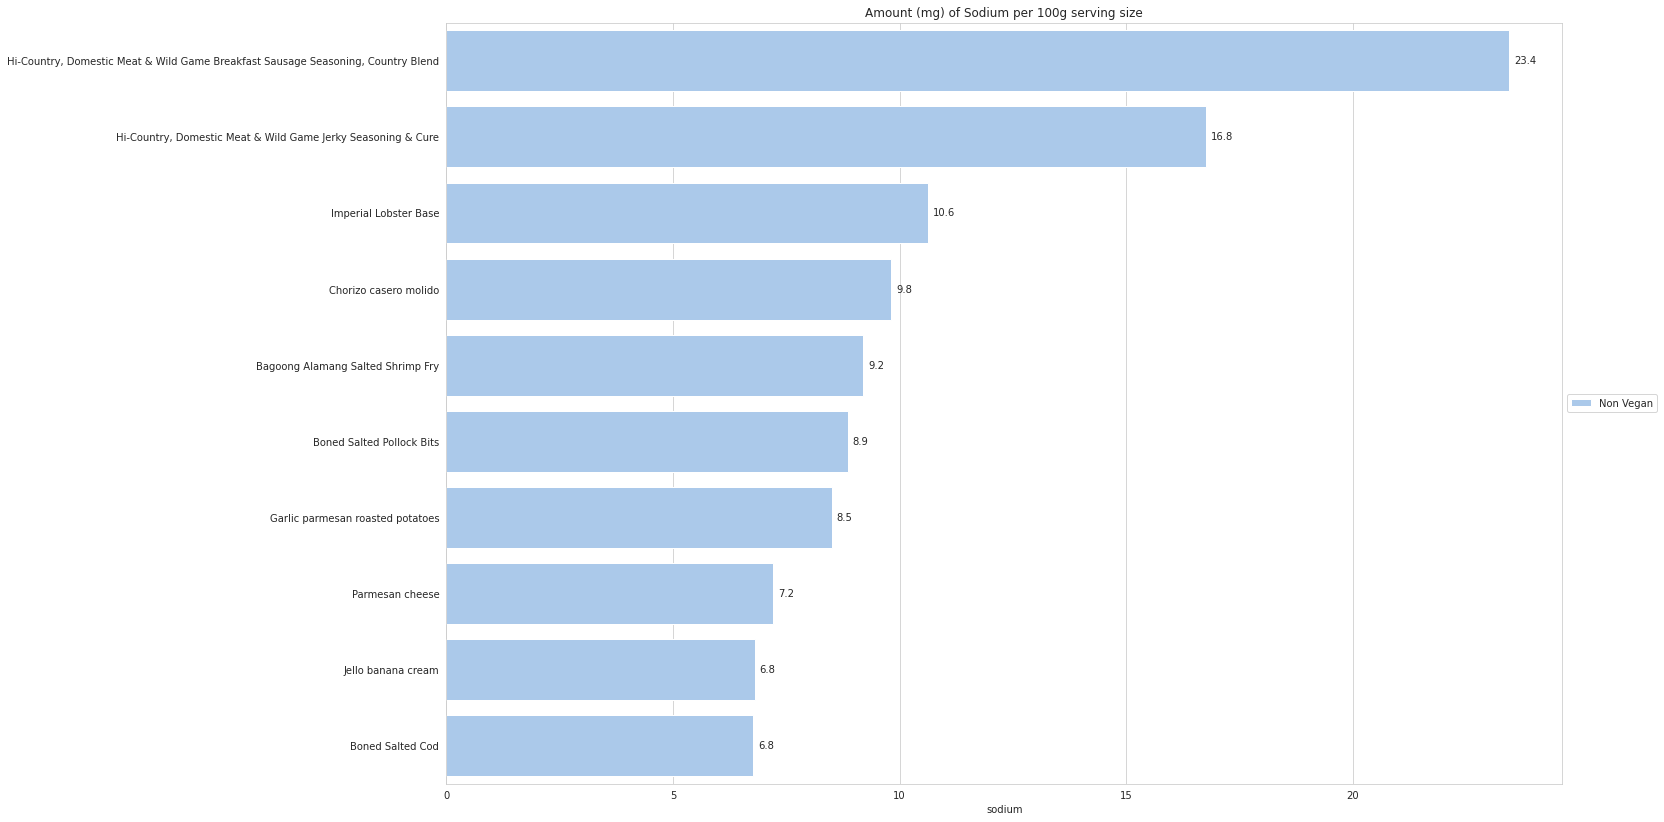

In [ ]:
sodium = veg_df.sort_values("Sodium", ascending=False)
sodium_10 = sodium.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=sodium_10, y="Name", x="Sodium", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sodium")
plt.ylabel("")
plt.title("Amount (mg) of Sodium per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

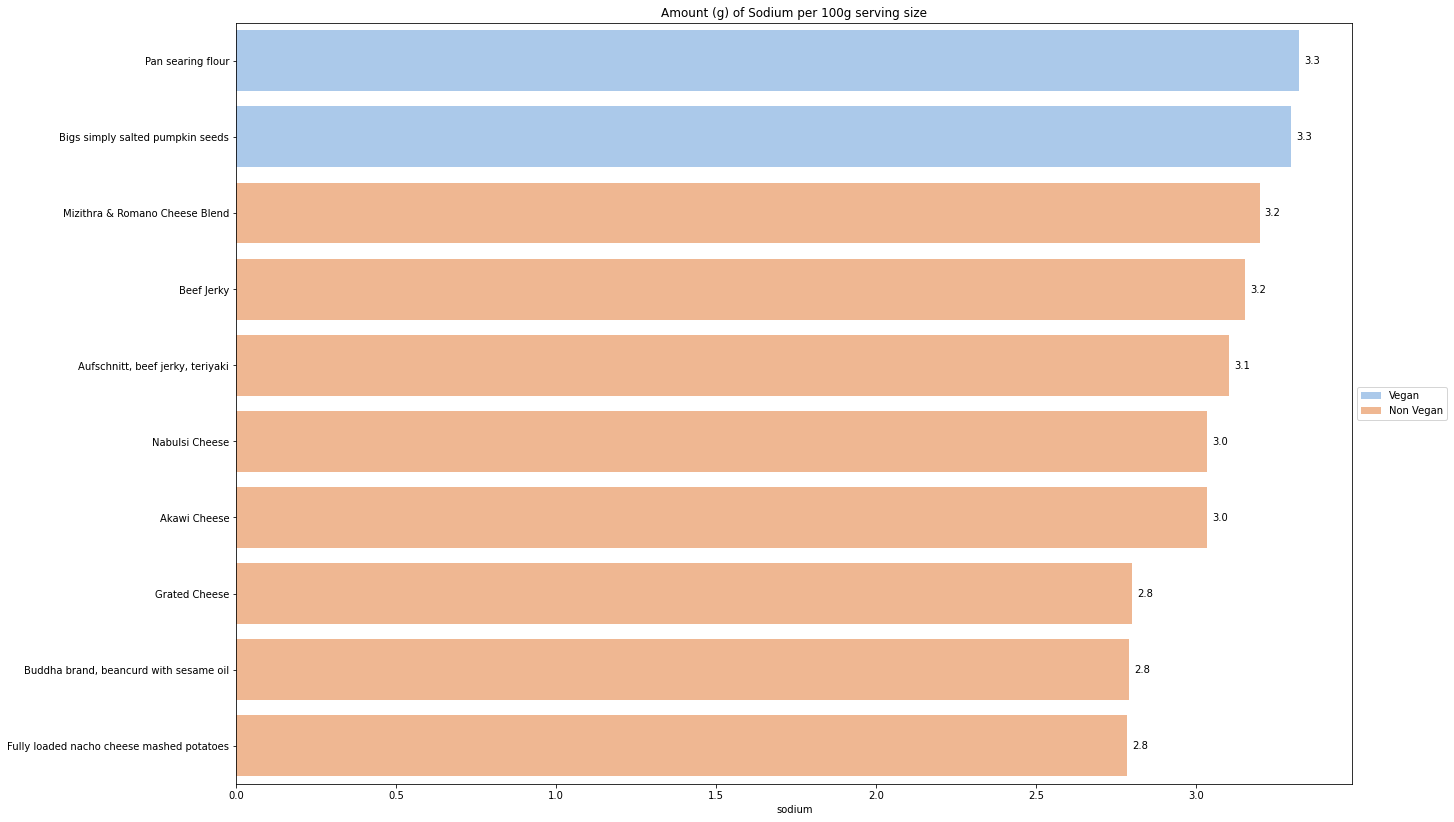

In [ ]:
sodium = veg_df.sort_values("Sodium", ascending=False)
sodium_10 = sodium.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=sodium_10, y="Name", x="Sodium", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sodium")
plt.ylabel("")
plt.title("Amount (g) of Sodium per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

Top **Saturated fat** rich Foods

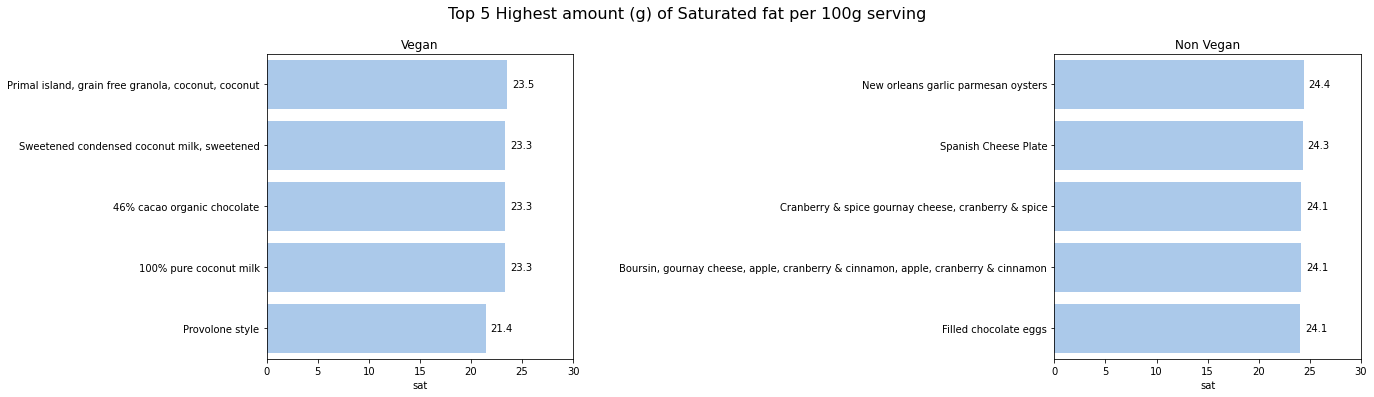

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle("Top 5 Highest amount (g) of Saturated fat per 100g serving", size=16)

#Vegan
plt.subplot(121)
sat = veg_df[veg_df["Label"]=="Vegan"].sort_values("Saturated fat", ascending=False)
sat_5 = sat.head(5)

cplot = sns.barplot(data=sat_5, y="Name", x="Saturated fat", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sat")
plt.ylabel("")
plt.title("Vegan", size=12)
# plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
cplot.legend([],[], frameon=False)
plt.xlim(right=30)

#Non
plt.subplot(122)
sat = veg_df[veg_df["Label"]=="Non Vegan"].sort_values("Saturated fat", ascending=False)
sat_5 = sat.head(5)

cplot = sns.barplot(data=sat_5, y="Name", x="Saturated fat", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("sat")
plt.ylabel("")
plt.title("Non Vegan", size=12)
# plt.legend(loc="upper left",  bbox_to_anchor=(0,1))
cplot.legend([],[], frameon=False)
plt.xlim(right=30)

plt.tight_layout(pad=4)
plt.show()

Top **Cholesterol-rich** foods

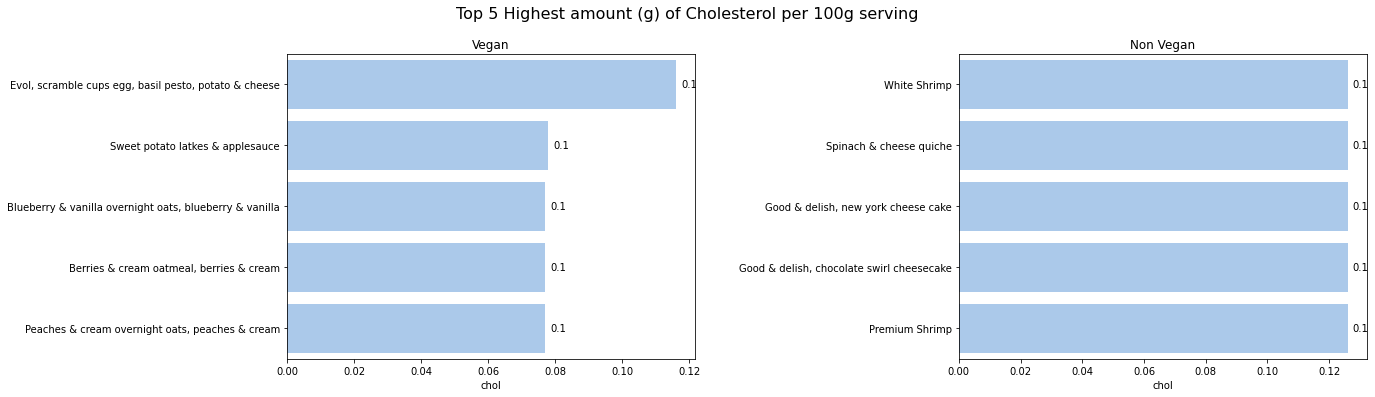

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle("Top 5 Highest amount (g) of Cholesterol per 100g serving", size=16)

#Vegan
plt.subplot(121)
chol = veg_df[veg_df["Label"]=="Vegan"].sort_values("Cholesterol", ascending=False)
chol_5 = chol.head(5)

cplot = sns.barplot(data=chol_5, y="Name", x="Cholesterol", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("chol")
plt.ylabel("")
plt.title("Vegan", size=12)
# plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
cplot.legend([],[], frameon=False)
# plt.xlim(right=115)

#Non
plt.subplot(122)
chol = veg_df[veg_df["Label"]=="Non Vegan"].sort_values("Cholesterol", ascending=False)
chol_5 = chol.head(5)

cplot = sns.barplot(data=chol_5, y="Name", x="Cholesterol", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("chol")
plt.ylabel("")
plt.title("Non Vegan", size=12)
# plt.legend(loc="upper left",  bbox_to_anchor=(0,1))
cplot.legend([],[], frameon=False)
# plt.xlim(right=8)

plt.tight_layout(pad=4)
plt.show()

Top **Sugar-rich** Foods

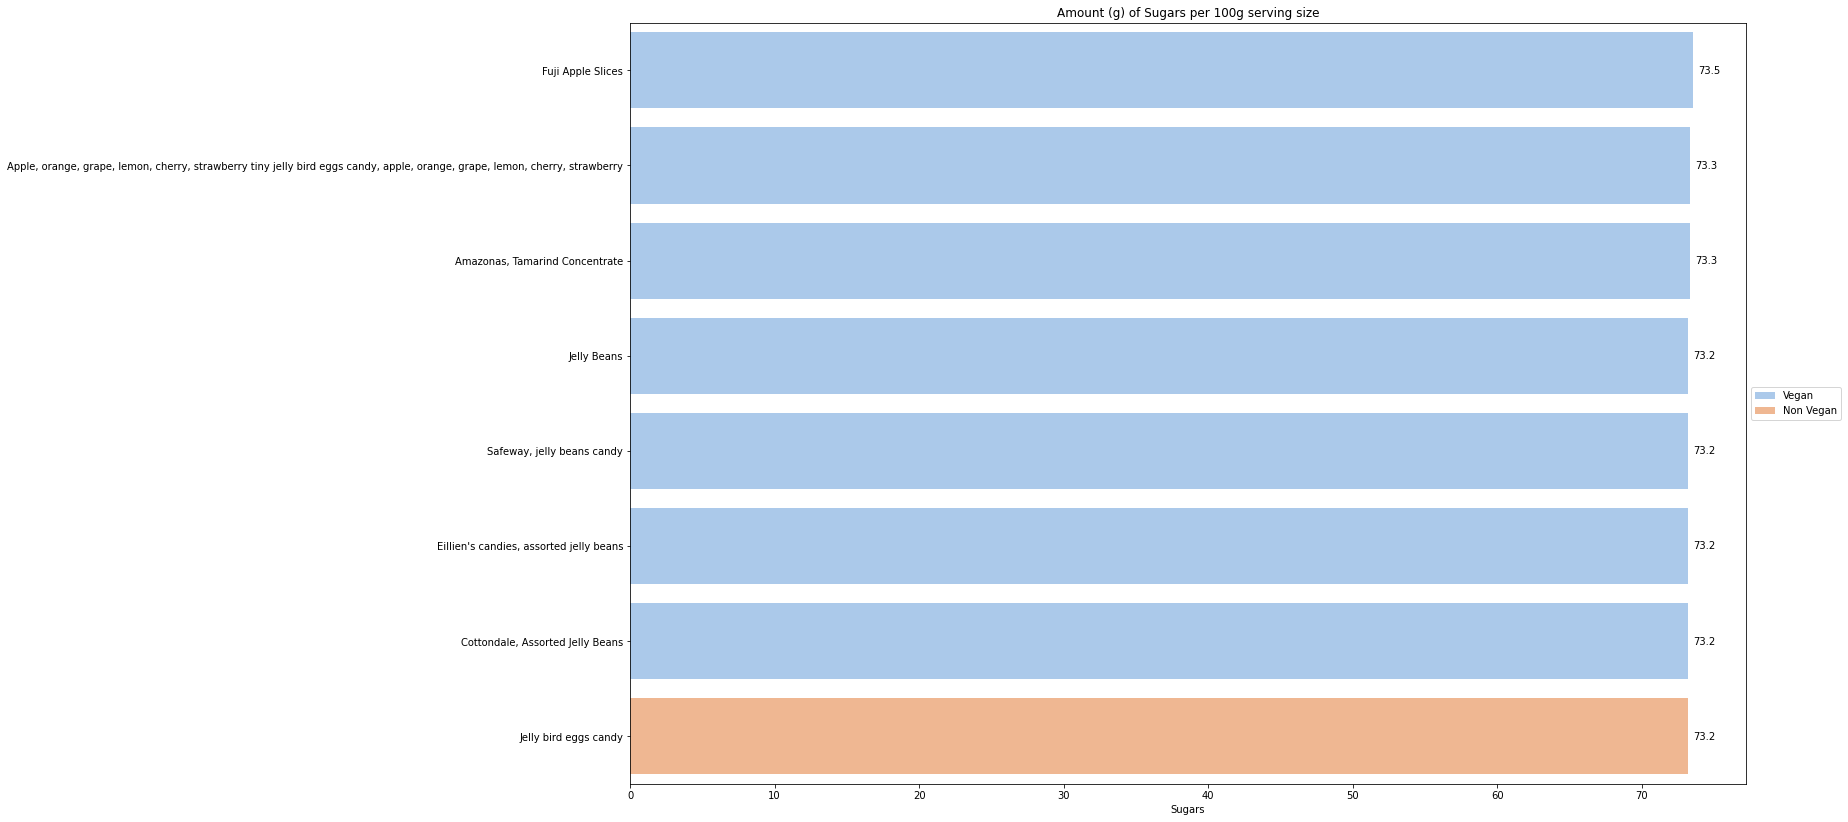

In [ ]:
sug = veg_df.sort_values("Sugars", ascending=False)
sug_10 = sug.head(10)
plt.figure(figsize=(20,14))
cplot = sns.barplot(data=sug_10, y="Name", x="Sugars", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Sugars")
plt.ylabel("")
plt.title("Amount (g) of Sugars per 100g serving size")
plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
plt.show()

####Good Nutrients

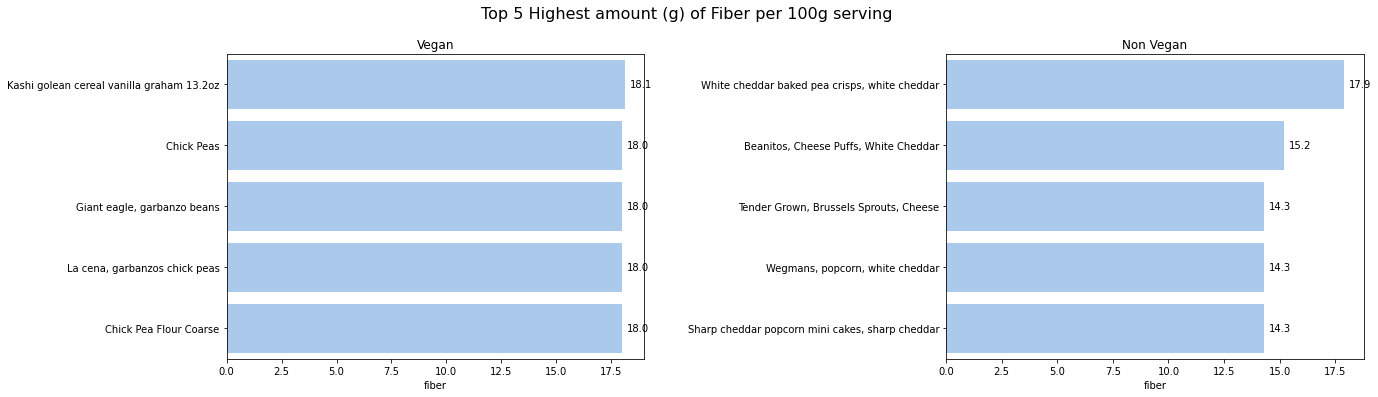

In [ ]:
plt.figure(figsize=(20,6))
plt.suptitle("Top 5 Highest amount (g) of Fiber per 100g serving", size=16)

#Vegan
plt.subplot(121)
fiber = veg_df[veg_df["Label"]=="Vegan"].sort_values("Fiber", ascending=False)
fiber_5 = fiber.head(5)

cplot = sns.barplot(data=fiber_5, y="Name", x="Fiber", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("fiber")
plt.ylabel("")
plt.title("Vegan", size=12)
# plt.legend(loc="center left",  bbox_to_anchor=(1.0, 0.5))
cplot.legend([],[], frameon=False)
# plt.xlim(right=115)

#Non
plt.subplot(122)
fiber = veg_df[veg_df["Label"]=="Non Vegan"].sort_values("Fiber", ascending=False)
fiber_5 = fiber.head(5)

cplot = sns.barplot(data=fiber_5, y="Name", x="Fiber", hue="Label", palette = 'pastel', dodge=False)
for p in cplot.patches:
  cplot.annotate("%.1f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("fiber")
plt.ylabel("")
plt.title("Non Vegan", size=12)
# plt.legend(loc="upper left",  bbox_to_anchor=(0,1))
cplot.legend([],[], frameon=False)
# plt.xlim(right=25)

plt.tight_layout(pad=4)
plt.show()

Top **Protein-rich** foods

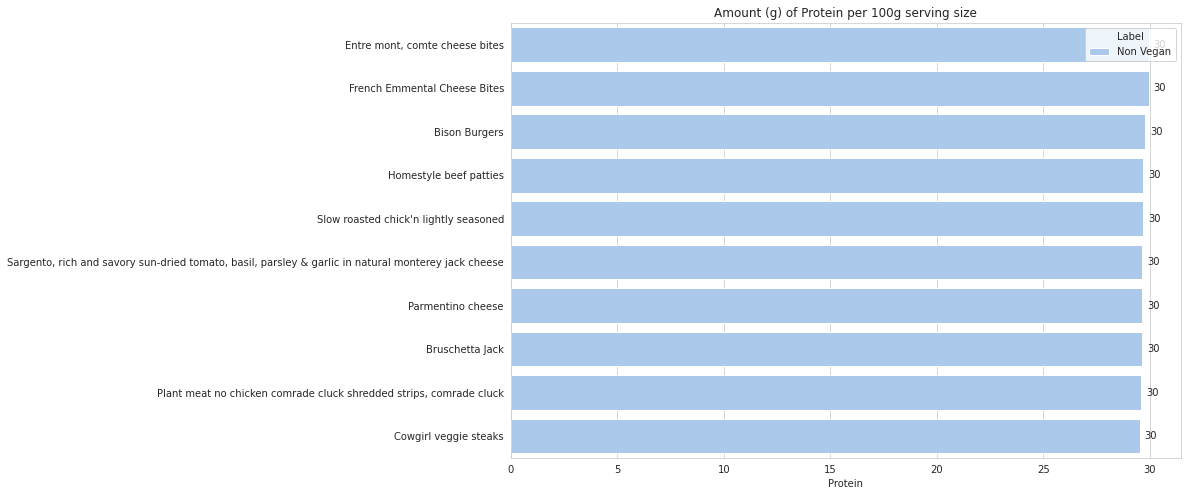

In [ ]:
pro = veg_df.sort_values("Protein", ascending=False)
pro_10 = pro.head(10)
plt.figure(figsize=(12,8))
sns.set_color_codes("pastel")
pplot = sns.barplot(data=pro_10, y="Name", x="Protein", hue="Label",palette = 'pastel', dodge=False)
for p in pplot.patches:
    pplot.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Protein")
plt.ylabel("")
plt.title("Amount (g) of Protein per 100g serving size")
plt.show()

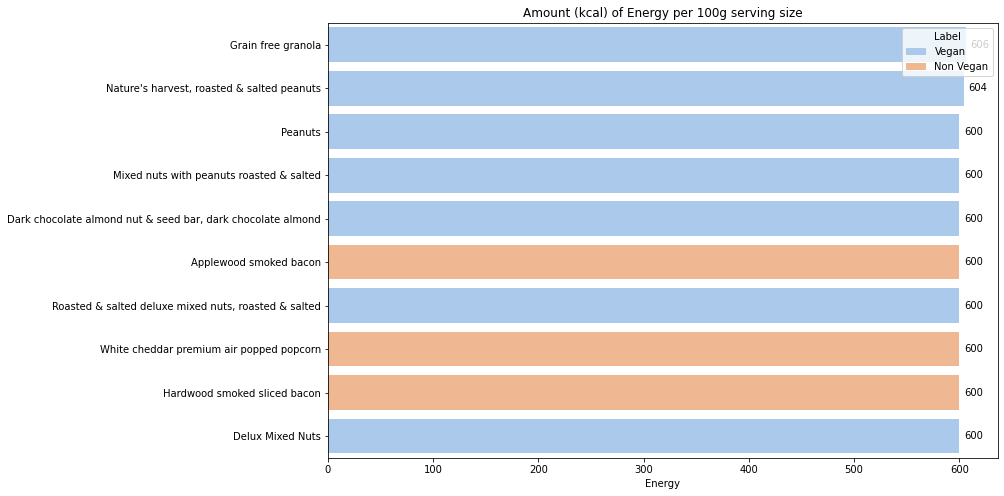

In [ ]:
ener = veg_df.sort_values("Energy_kcal", ascending=False)
ener_10 = ener.head(10)
plt.figure(figsize=(12,8))
sns.set_color_codes("pastel")
pplot = sns.barplot(data=ener_10, y="Name", x="Energy_kcal", hue="Label",palette = 'pastel', dodge=False)
for p in pplot.patches:
    pplot.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.xlabel("Energy")
plt.ylabel("")
plt.title("Amount (kcal) of Energy per 100g serving size")
plt.show()

##Categories and Nutrition

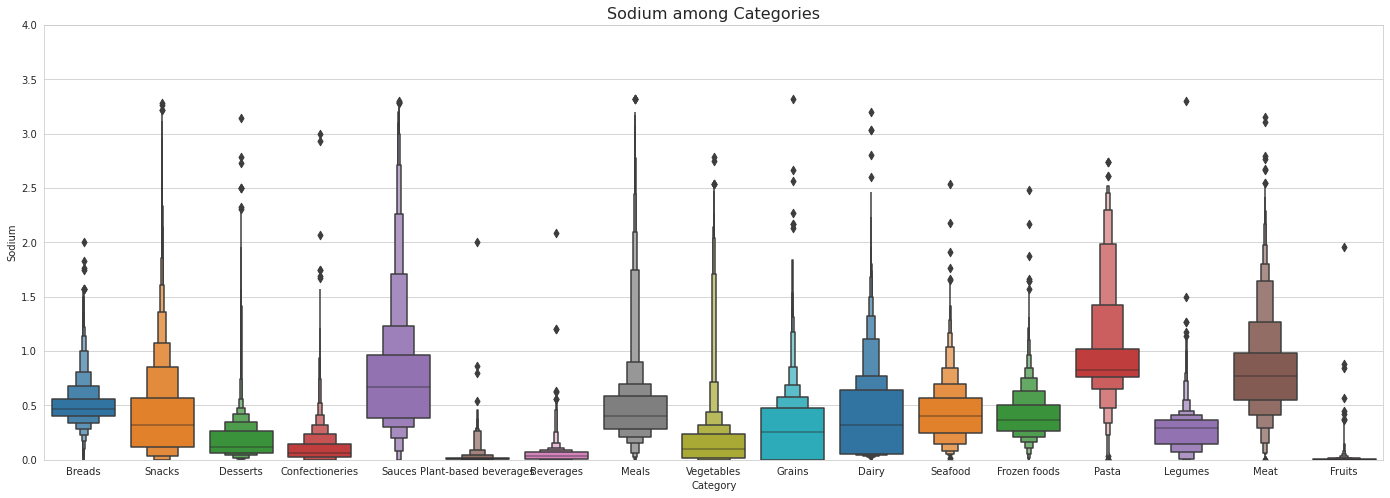

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(24,8))

Sodium_df = data[data.Sodium < 10]
ax = sns.boxenplot(x="Category", y='Sodium', data=Sodium_df, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.title("Sodium among Categories", size=16)
plt.ylim(bottom=0, top=4)
plt.show()

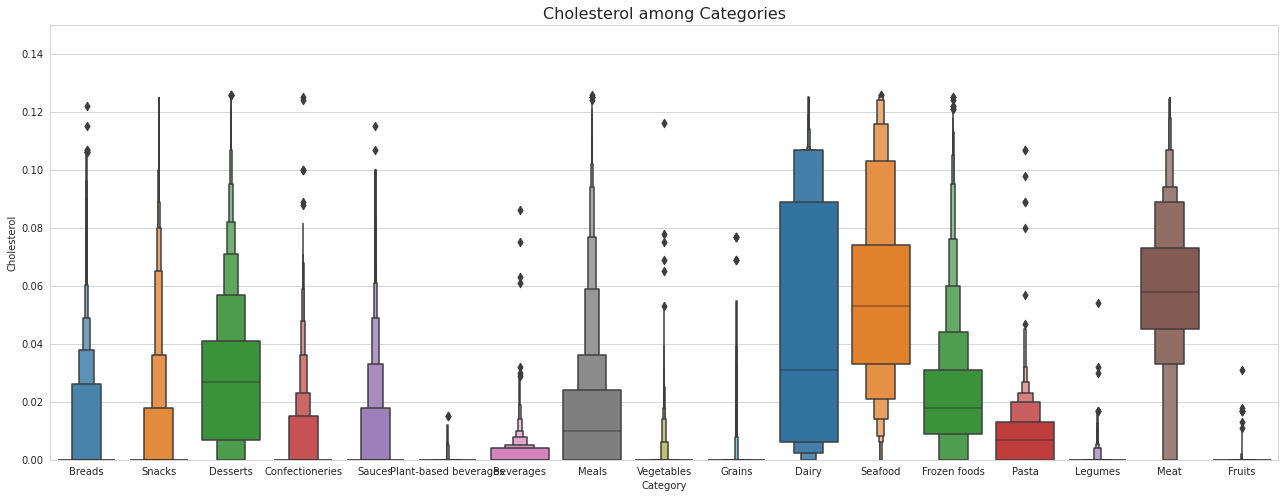

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

chol_data = data[data.Cholesterol < 1]
ax = sns.boxenplot(x="Category", y='Cholesterol', data=chol_data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.title("Cholesterol among Categories", size=16)
plt.ylim(bottom=0, top=0.15)
plt.show()

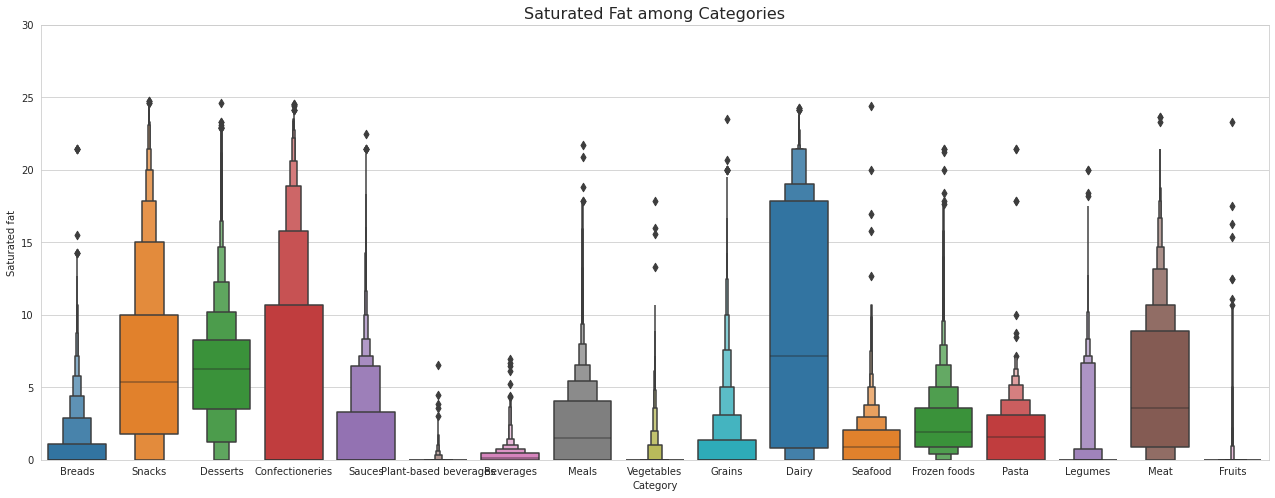

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

sat_data = data[data["Saturated fat"] < 70]
ax = sns.boxenplot(x="Category", y='Saturated fat', data=sat_data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Saturated Fat among Categories", size=16)
plt.ylim(bottom=0, top=30)
plt.show()

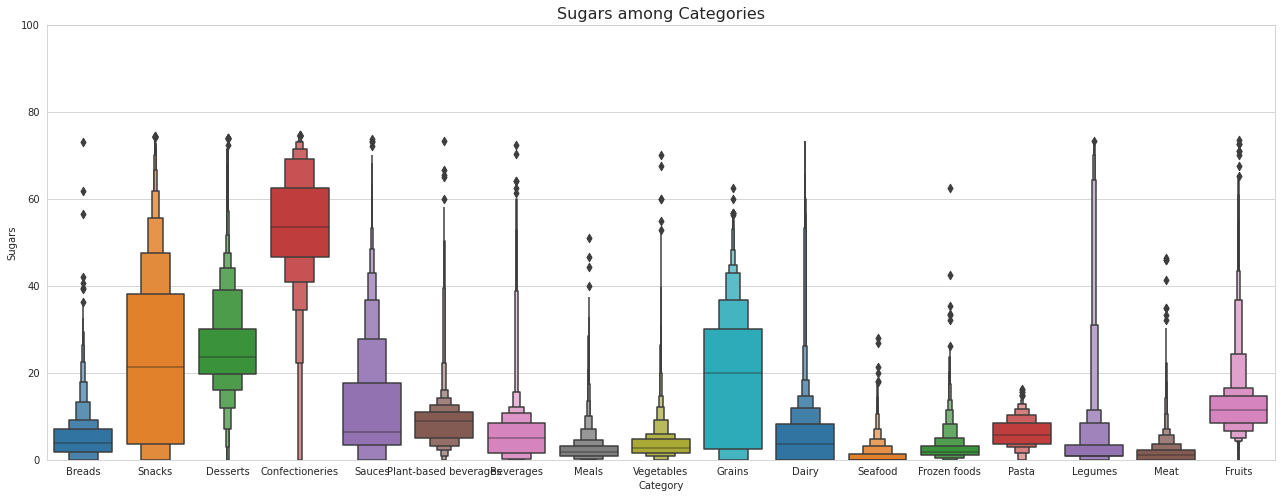

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

sug_data = data[data.Sugars < 100]
ax = sns.boxenplot(x="Category", y='Sugars', data=sug_data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Sugars among Categories", size=16)
plt.ylim(bottom=0, top=100)
plt.show()

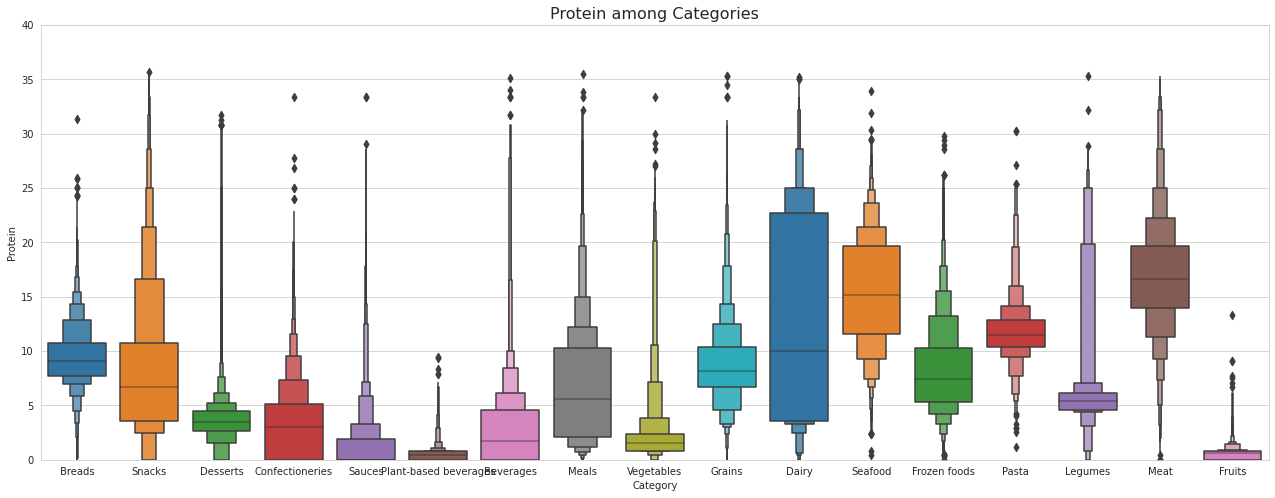

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))
# pro_df = df[df.Protein < 80]
ax = sns.boxenplot(x="Category", y='Protein', data=data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
plt.title("Protein among Categories", size=16)
plt.ylim(bottom=0, top=40)
plt.show()

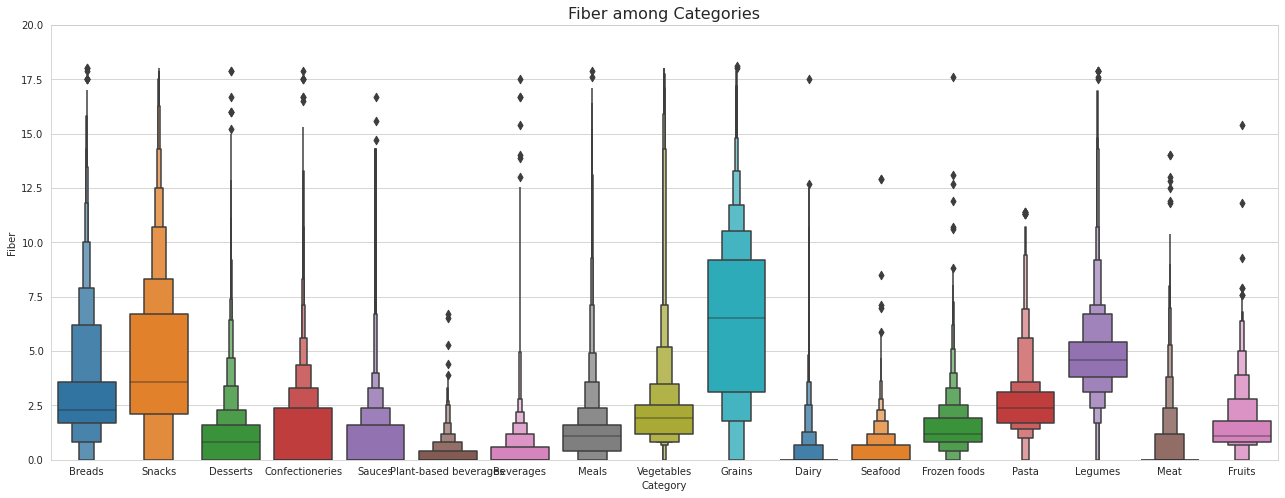

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))

# fib_df = df[df.Fiber<50]
ax = sns.boxenplot(x="Category", y='Fiber', data=data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))
    
plt.title("Fiber among Categories", size=16)
plt.ylim(bottom=0, top=20)
plt.show()

##Additives

###Why additives?

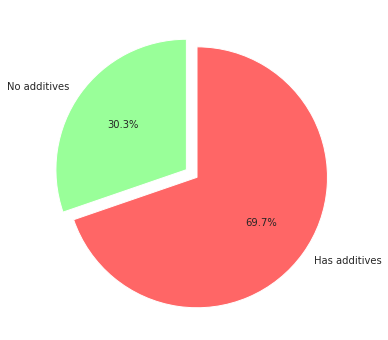

In [ ]:
plt.figure(figsize=(10,6))
with_adds = data[data["Additives_count"]>0]
no_adds = data[data["Additives_count"]==0]
labels= ["No additives","Has additives"]
colors = ['#99ff99','#ff6666']
plt.pie([len(no_adds),len(with_adds)], colors=colors, labels=labels, autopct='%.1f%%',startangle=90, explode=(0,0.1))

plt.show()

Does Additives really affect the nutrition value?

In [ ]:
additives_by_grade = data.groupby("nutri_grade")["Additives_count"]

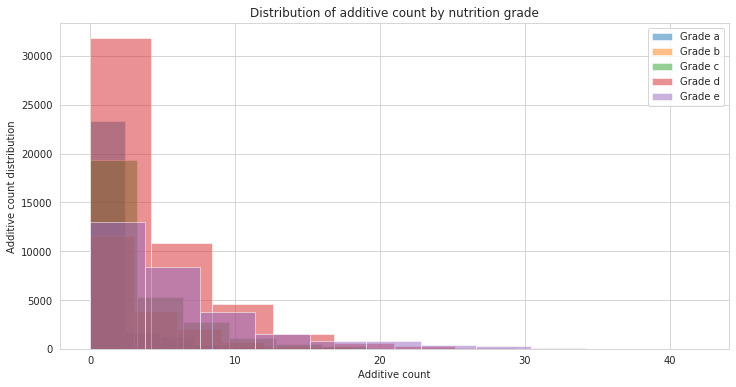

In [ ]:
plt.figure(figsize=(12,6))
for additive, grade in additives_by_grade:
    plt.hist(grade, label = "Grade {}".format(additive), alpha = 0.5)
plt.title("Distribution of additive count by nutrition grade")
plt.xlabel("Additive count")
plt.ylabel("Additive count distribution")
plt.legend()
plt.show()

It seems like the distribution of additives count for each grade is similar. However, we can see that Grade D is the dominant grade in the total products

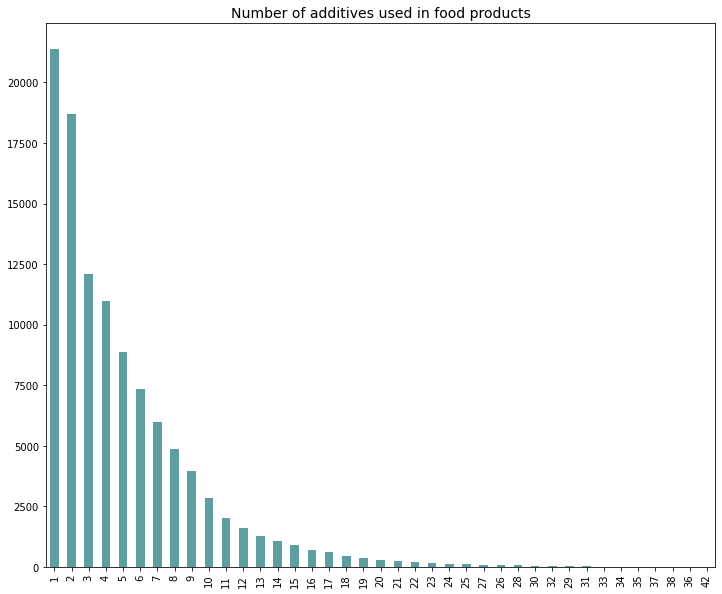

In [ ]:
plt.figure(figsize=(12,10))
df[df['Additives_count'] > 0]['Additives_count'].value_counts().plot(kind='bar',color='cadetblue')
plt.title('Number of additives used in food products',fontsize=14)
plt.show()

####Let's dive deeper into the additives

In [ ]:
additives = (df['additives'].str.extractall("(?P<Count>[E]\d\d\d\w?)"))
additives_count = additives.apply(pd.value_counts).head(30)
additives_count['Enum'] = additives_count.index
additives_count.reset_index(drop=True,inplace=True)

In [ ]:
additives_mapping = {'E330': 'orange','E322':'purple','E322i':'purple','E101':'blue','E375':'orange','E101i':'blue',
                    'E300':'cyan','E415':'purple','E412':'orange','E500':'orange','E471':'purple','E203':'forestgreen','E407':'purple',
                    'E440':'purple','E250':'forestgreen','E150a':'blue','E450':'orange','E500i':'blue','E331':'orange',
                     'E129':'orange','E339':'orange','E440i':'purple','E160a':'blue','E270':'orange','E102':'blue',
                     'E410':'purple','E133':'blue','E341':'orange','E428':'purple','E621':'orange','E202':'blue','E150c':'blue','E200':'forestgreen','E282':'forestgreen','E316':'cyan',
                     'E341i':'cyan','E160b':'blue','E110':'blue','E211':'forestgreen','E414':'purple','E422':'orange','E450i':'orange','E466':'purple'}

additives_count['Colors'] = additives_count['Enum'].map(additives_mapping)

In [ ]:
additives_count.sort_values("Colors")

,Count,Enum,Colors
3,23912,E500i,blue
25,6543,E160a,blue
21,8982,E110,blue
8,13830,E202,blue
19,9592,E133,blue
10,12820,E150c,blue
17,10475,E160b,blue
15,11072,E102,blue
14,11286,E341i,cyan
26,6332,E282,forestgreen


In [ ]:
def add_check(row):
  if row == "blue":
    return "Colors"
  elif row == "orange":
    return "Others"
  elif row == "purple":
    return "Emulsifiers"
  elif row == "orchid":
    return "Sweeteners"
  elif row == "cyan":
    return "Antioxidants"
  elif row == "forestgreen":
    return "Preservatives"

In [ ]:
additives_count["Type"] = additives_count["Colors"].apply(add_check)
additives_count.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/additives_count.csv", index=False)
additives_count

,Count,Enum,Colors,Type
0,46882,E330,orange,Others
1,40553,E322,purple,Emulsifiers
2,40479,E322i,purple,Emulsifiers
3,23912,E500i,blue,Colors
4,23907,E500,orange,Others
5,23447,E415,purple,Emulsifiers
6,19147,E412,orange,Others
7,18468,E471,purple,Emulsifiers
8,13830,E202,blue,Colors
9,13709,E407,purple,Emulsifiers


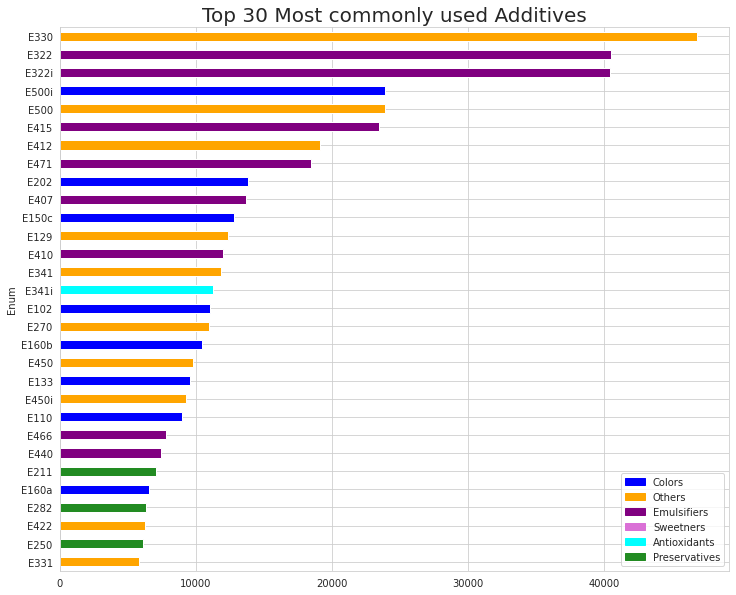

In [ ]:
import matplotlib.patches as mpatches

aplot = additives_count.plot(x='Enum',y='Count',kind='barh',color=additives_count['Colors'],figsize=(12,10))
aplot.invert_yaxis()
aplot.legend().set_visible(False)
aplot.set_title('Top 30 Most commonly used Additives',{'fontsize':20})

colors = mpatches.Patch(color='blue', label='Colors')
others = mpatches.Patch(color='orange', label='Others')
emulsifiers = mpatches.Patch(color='purple', label='Emulsifiers')
sweetners = mpatches.Patch(color='orchid', label='Sweetners')
antioxidant = mpatches.Patch(color='cyan', label='Antioxidants')
preservatives = mpatches.Patch(color='forestgreen', label='Preservatives')

plt.legend(handles=[colors,others,emulsifiers,sweetners,antioxidant,preservatives])
plt.savefig("30adds.jpg",dpi=300)
plt.show()

###Category-wise

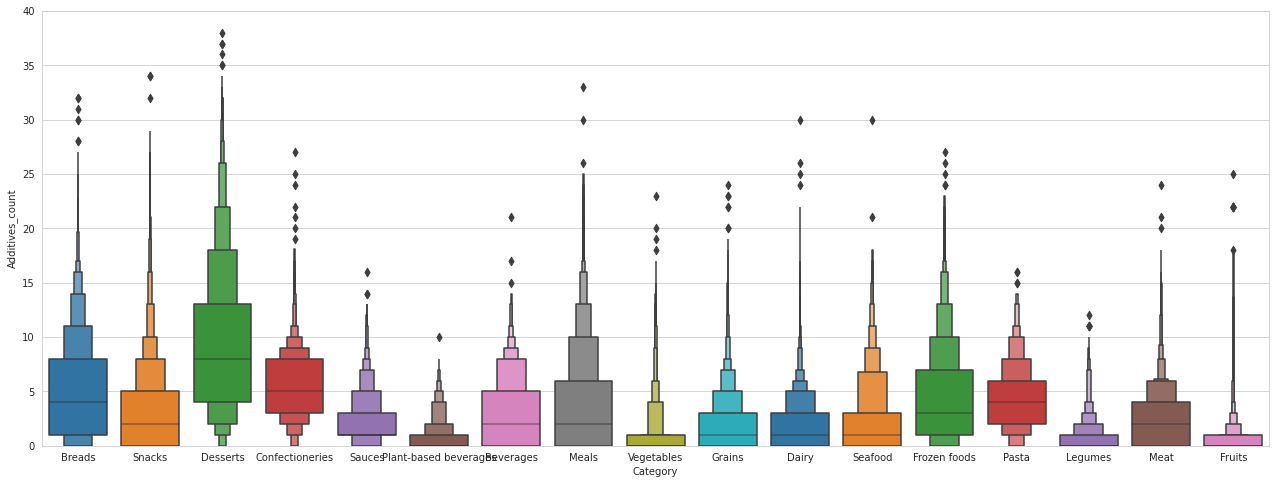

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(22,8))
# pro_df = df[df.Protein < 80]
ax = sns.boxenplot(x="Category", y='Additives_count', data=data, color='#eeeeee', palette="tab10")

# Add transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .9))

plt.ylim(bottom=0, top=40)
plt.savefig("adds_cat.jpg",dpi=300)
plt.show()

###Which product has the most Additives

In [ ]:
data[(data.Additives_count == data[data["Label"]=="Non Vegan"]["Additives_count"].max()) & (data.Label=="Non Vegan")][["Name","Ingredients","nutri_grade","nova_grade","additives", "Additives_count"]]

,Name,Ingredients,nutri_grade,nova_grade,additives,Additives_count
250543,"The bakery, apple pie mini cupcakes, cinnamon cream cheese","Sugar, water, bleached enriched wheat flour (flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid), vegetable oil (soybean, palm, palm kernel, canola), cornstarch, eggs, corn syrup, nonfat milk, leavening (sodium acid pyrophosphate, baking soda, monocalcium phosphate, sodium aluminum phosphate, aluminum sulfate), egg whites, salt, food starch-modified, mono - and diglycerides, whey, malic acid, wheat starch, natural & artificial flavors, soy lecithin, citrus fiber, cinnamon, polyglycerol esters of fatty acids, xanthan gum, polysorbate 60, glycerin, gum arabic, potassium sorbate (preservative), sodium stearoyl lactylate, fructose, wheat protein, datem, calcium stearoyl-2-lactylate, cellulose, cream cheese powder (cream cheese (pasteurized milk, cheese culture, salt, carob bean gum), sodium caseinate (milk), disodium phosphate, natural flavor, bha), sodium carboxymethylcellulose, methylcellulose, caramel color, beta carotene (color), sucralose, turmeric color, paprika, yellow 5 lake, yellow 6 lake, red 40 lake, blue 1 lake.",e,4.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E129 - Allura red ac,E133 - Brilliant blue FCF,E150c - Ammonia caramel,E160a - Carotene,E160ai - Beta-carotene,E202 - Potassium sorbate,E296 - Malic acid,E320 - Butylated hydroxyanisole (bha),E322 - Lecithins,E322i - Lecithin,E339ii - Disodium phosphate,E341 - Calcium phosphates,E341i - Monocalcium phosphate,E410 - Locust bean gum,E414 - Acacia gum,E415 - Xanthan gum,E422 - Glycerol,E435 - Polyoxyethylene sorbitan monostearate,E450 - Diphosphates,E450i - Disodium diphosphate,E460 - Cellulose,E461 - Methyl cellulose,E466 - Sodium carboxy methyl cellulose,E471 - Mono- and diglycerides of fatty acids,E472e - Mono- and diacetyltartaric acid esters of mono- and diglycerides of fatty acids,E475 - Polyglycerol esters of fatty acids,E481 - Sodium stearoyl-2-lactylate,E482 - Calcium stearoyl-2-lactylate,E500 - Sodium carbonates,E500ii - Sodium hydrogen carbonate,E520 - Aluminium sulphate,E541 - Sodium aluminium phosphate,E955 - Sucralose",35


In [ ]:
data[(data.Additives_count == data[data["Label"]=="Vegan"]["Additives_count"].max()) & (data.Label=="Vegan")][["Name","Ingredients","nutri_grade","nova_grade","additives", "Additives_count"]]

,Name,Ingredients,nutri_grade,nova_grade,additives,Additives_count
135327,Chiffon mist creme dessert,"Water, sugar, high fructose corn syrup, mandarin oranges, pineapple (pineapple, pineapple juice), hydrogenated palm kernel oil, coconut oil, nonfat dry milk, strawberries, modified corn starch, gelatin, maraschino cherries, lactic acid, mono & diglycerides, citric acid, potassium sorbate & sodium benzoate (preservatives), corn syrup, citrus fiber, natural & artificial flavors, locust bean gum, sodium citrate, xanthan gum, sunflower lecithin, salt, guar gum, dextrose, polysorbate 60, polyglycerol esters of fatty acids, methylcellulose, soy lecithin, disodium phosphate, carrageenan, red 40, beta carotene (color), yellow 6, oil of bitter almond, red 3, yellow 5, caramel color, blue 1.",c,4.0,"E102 - Tartrazine,E110 - Sunset yellow FCF,E127 - Erythrosine,E129 - Allura red ac,E133 - Brilliant blue FCF,E150c - Ammonia caramel,E160a - Carotene,E160ai - Beta-carotene,E202 - Potassium sorbate,E211 - Sodium benzoate,E270 - Lactic acid,E322 - Lecithins,E322i - Lecithin,E330 - Citric acid,E331 - Sodium citrates,E339ii - Disodium phosphate,E407 - Carrageenan,E410 - Locust bean gum,E412 - Guar gum,E415 - Xanthan gum,E428 - Gelatine,E435 - Polyoxyethylene sorbitan monostearate,E461 - Methyl cellulose,E471 - Mono- and diglycerides of fatty acids,E475 - Polyglycerol esters of fatty acids",25


##Relationship

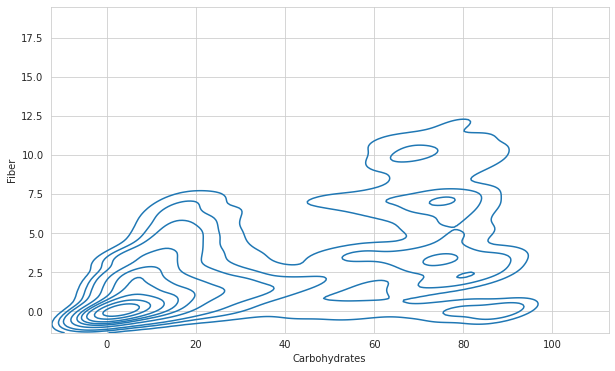

In [ ]:
plt.figure(figsize=(10,6))
cf_df = veg_df[veg_df["Label"]=="Vegan"]
sns.kdeplot(x=veg_df["Carbohydrates"], y=veg_df["Fiber"], palette="pastel")
plt.show()

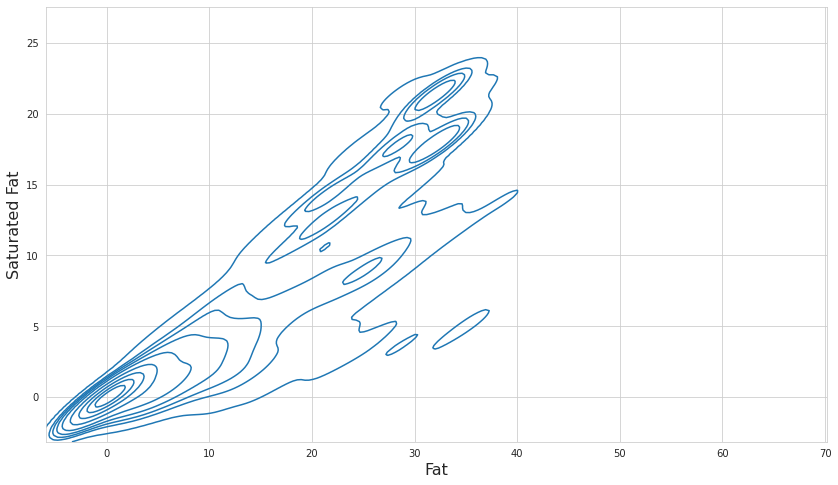

In [ ]:
plt.figure(figsize=(14,8))
cf_df = veg_df[veg_df["Label"]=="Vegan"]
sns.kdeplot(x=veg_df["Fat"], y=veg_df["Saturated fat"], palette="pastel")
plt.xlabel("Fat", size=16)
plt.ylabel("Saturated Fat", size=16)
plt.savefig("sat_fat.jpg",dpi=300)
plt.show()

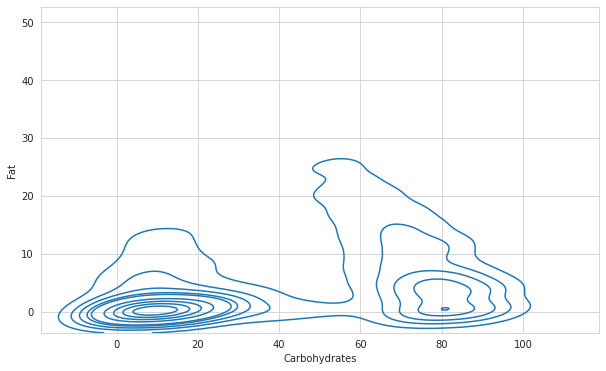

In [ ]:
plt.figure(figsize=(10,6))
cf_df = veg_df[veg_df["Label"]=="Vegan"]
sns.kdeplot(x=cf_df["Carbohydrates"], y=cf_df["Fat"], palette="pastel")
plt.show()

#**E. Classification**

##1. Visualize the distribution of the label

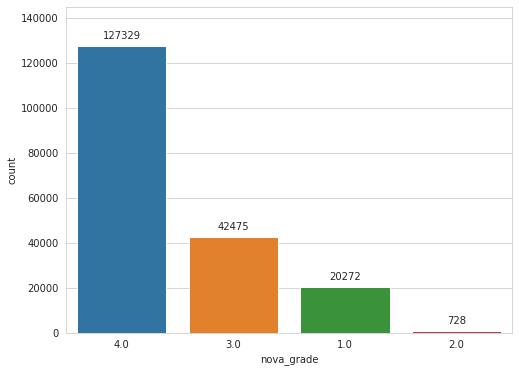

In [ ]:
nova_count = df_nova['nova_grade'].value_counts().reset_index()
nova_count = nova_count.rename(columns={'index':'nova_grade','nova_grade':'count'})
nova_count.sort_values('count',ascending=False,inplace=True)

plt.figure(figsize=(8,6))
plt.subplot()
nplot = sns.barplot(data=nova_count, x='nova_grade',y='count',order=nova_count['nova_grade'].values)

for p in nplot.patches:
  nplot.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()+10000),
                 ha = 'center', va='center',
                 xytext=(0,-12),
                textcoords = 'offset points')
plt.ylim(top=145000)
plt.show()

Due to the imbalanced nature of the target, SMOTE method which is an Over-sampling approach that creates synthetic minority class samples will be implemented in the pipeline

##Split data

In [ ]:
X = df_nova.drop(columns=['nova_grade'])
y = df_nova['nova_grade']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(152643, 11) (152643,)
(38161, 11) (38161,)


In [ ]:
def get_samples(n_samples, X, y=None):
  """Get n_samples randomly from dataset"""
  np.random.seed(42)
  samples_index = np.random.choice(np.arange(len(X)), n_samples, replace=False)
  if not y is None:
    return X.iloc[samples_index], y.iloc[samples_index]  
  return X.iloc[samples_index]

# Get a smaller sample size for faster training
n_samples = 50000
X_train_sample, y_train_sample = get_samples(n_samples, X_train, y_train)

## Baseline model

###Dummy Classifier

DummyClassifier is a classifier model that makes predictions without trying to find patterns in the data

              precision    recall  f1-score   support

         1.0      0.103     0.254     0.146      4835
         2.0      0.010     0.252     0.019       468
         3.0      0.212     0.251     0.230     10176
         4.0      0.678     0.249     0.364     32351

    accuracy                          0.250     47830
   macro avg      0.251     0.251     0.190     47830
weighted avg      0.514     0.250     0.310     47830



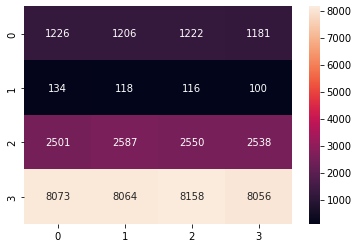

In [ ]:
pipe_dum = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DummyClassifier(strategy='stratified'))
                    ])

pipe_dum.fit(X_train, y_train)

y_pred = pipe_dum.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:", accuracy_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, pipe_dum.predict_proba(X_test), multi_class='ovo'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.24984319464771065
ROC_AUC: 0.5007015396264499
F1: 0.3102046366584849
Fbeta: 0.21292835836162838


##Benchmark (Cross-val)

In [ ]:
models_dict = {"Dummy Classifier": DummyClassifier(),
            "Logistic Regression": LogisticRegression(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "RandomForestClassifier": RandomForestClassifier(),
            "LGBMClassifier": LGBMClassifier()
  }
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

metrics = {"Accuracy": "accuracy",
           "F1_weighted": "f1_weighted",
           "Fbeta": fbeta,
           "ROC_AUC": roc_auc}
           
cv = KFold(n_splits=5, shuffle=True, random_state=42)           

In [ ]:
# Benchmark cross-validation scores for training data of 180K
for model_name, model in models_dict.items():
  print(model_name + ":")
  for metric_name, metric in metrics.items():
    pipe = Pipeline([('smt', SMOTE(random_state=42)),  
                    ('scaler',StandardScaler()),
                    (model_name, model)])
    
    score = np.mean(cross_val_score(pipe, X_train, y_train, cv=cv, scoring= metric))
    print("\t" + metric_name + f": {score}")
  # print("\n")

Dummy Classifier:
	Accuracy: 0.25023232191811673
	F1_weighted: 0.3112457917310036
	Fbeta: 0.40191470351984576
	ROC_AUC: 0.49846583094545077
Logistic Regression:
	Accuracy: 0.7312270891754594
	F1_weighted: 0.7571801586580211
	Fbeta: 0.7862144622676099
	ROC_AUC: 0.9258979482625188
DecisionTreeClassifier:
	Accuracy: 0.8751880589481992
	F1_weighted: 0.8763441894478484
	Fbeta: 0.8770437083875942
	ROC_AUC: 0.8977670939575116
RandomForestClassifier:
	Accuracy: 0.9064228618406934
	F1_weighted: 0.9071816827686838
	Fbeta: 0.907563489439349
	ROC_AUC: 0.9788602657577117
LGBMClassifier:
	Accuracy: 0.8519624852750661
	F1_weighted: 0.8558707846898372
	Fbeta: 0.8606213346182308
	ROC_AUC: 0.9735314377417719


In [ ]:
#put in df
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

def baseline_report_cv_(model, X_train, y_train, n_splits, name):
  cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)   

  accuracy     = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='accuracy'))
  f1_weighted      = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='f1_weighted'))
  fbeta_score  = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring= fbeta))
  rocauc       = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring=roc_auc))

  scores_df = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'f1_weighted'      : [f1_weighted],
                             'fbeta'        : [fbeta_score],
                             'rocauc'       : [rocauc]})
  return scores_df

In [ ]:
pipe_dum = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DummyClassifier(strategy='stratified'))
                    ])
pipe_lr = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LogisticRegression())
                    ])
pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])
pipe_dtc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DecisionTreeClassifier())])
pipe_lgbm = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LGBMClassifier())
                    ])

In [ ]:
scores_df = pd.concat([baseline_report_cv_(pipe_dum, X_train, y_train, 5, 'DummyClassifier'),
                       baseline_report_cv_(pipe_lr, X_train, y_train, 5, 'LogisticRegression'),
                       baseline_report_cv_(pipe_rfc, X_train, y_train, 5, 'DecisionTreeClassifier'),
                       baseline_report_cv_(pipe_dtc, X_train, y_train, 5, 'RandomForestClassifier'),
                       baseline_report_cv_(pipe_lgbm, X_train, y_train, 5, 'LGBMClassifier')
                       ], axis=0).reset_index()

In [ ]:
scores = scores_df.drop("index", axis=1)
scores.index +=1
scores

,model,accuracy,f1_weighted,fbeta,rocauc
1,DummyClassifier,0.250607,0.311207,0.398239,0.503446
2,LogisticRegression,0.722981,0.751057,0.781360,0.920968
3,DecisionTreeClassifier,0.904365,0.905091,0.905551,0.976237
4,RandomForestClassifier,0.872408,0.873689,0.874652,0.894013
5,LGBMClassifier,0.849421,0.853567,0.858507,0.971897


In [ ]:
scores.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/nova_benchmark_df.csv", index=False)

In [ ]:
scores = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_benchmark_df.csv")

**Comment:** Random Forest Classifier has the highest scores for all metrics and will be fine-tuned for the Final Model 

##Benchmark

####Logistic Regression

              precision    recall  f1-score   support

         1.0      0.575     0.871     0.693      4835
         2.0      0.136     0.895     0.236       468
         3.0      0.491     0.566     0.525     10176
         4.0      0.949     0.754     0.840     32351

    accuracy                          0.727     47830
   macro avg      0.538     0.771     0.574     47830
weighted avg      0.806     0.727     0.752     47830



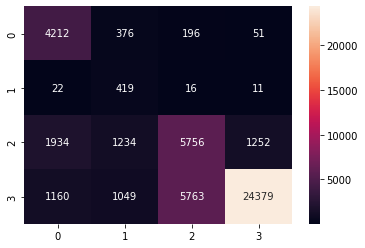

In [ ]:
pipe_lr = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LogisticRegression())
                    ])

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:", accuracy_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, pipe_lr.predict_proba(X_test), multi_class='ovo'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.7268659836922433
ROC_AUC: 0.9277030239614207
F1: 0.752292089806005
Fbeta: 0.546701322739955


####KNN

              precision    recall  f1-score   support

         1.0      0.815     0.919     0.863      4586
         2.0      0.546     0.893     0.678       422
         3.0      0.686     0.811     0.743      9536
         4.0      0.956     0.875     0.914     30655

    accuracy                          0.866     45199
   macro avg      0.751     0.874     0.800     45199
weighted avg      0.881     0.866     0.870     45199



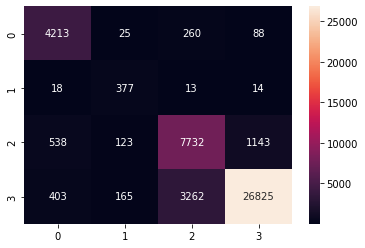

In [ ]:
pipe_knn = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',KNeighborsClassifier())
                    ])

pipe_knn.fit(X_train, y_train)

y_pred = pipe_knn.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_knn.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.8661032323723976
ROC_AUC: 0.9494179071109583
F1 0.870385740402514
Fbeta 0.768057568188266


####Random Forest

              precision    recall  f1-score   support

         1.0      0.886     0.926     0.906      4835
         2.0      0.716     0.876     0.788       468
         3.0      0.802     0.815     0.809     10176
         4.0      0.950     0.936     0.943     32351

    accuracy                          0.909     47830
   macro avg      0.838     0.888     0.861     47830
weighted avg      0.910     0.909     0.909     47830



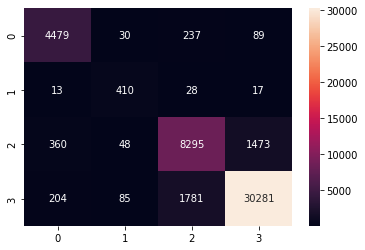

In [ ]:
pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])
pipe_rfc.fit(X_train, y_train)

y_pred = pipe_rfc.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_rfc.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.9087392849675936
ROC_AUC: 0.9797257819584487
F1 0.9092286879024433
Fbeta 0.8471695609866265


####SVC

              precision    recall  f1-score   support

         1.0      0.631     0.908     0.744      4586
         2.0      0.218     0.919     0.352       422
         3.0      0.544     0.671     0.600      9536
         4.0      0.954     0.780     0.858     30655

    accuracy                          0.771     45199
   macro avg      0.586     0.819     0.639     45199
weighted avg      0.828     0.771     0.787     45199



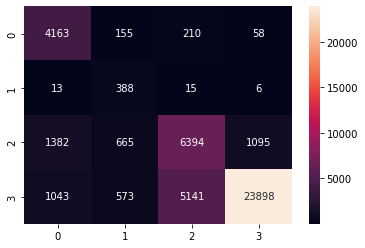

In [ ]:
pipe_svc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',MinMaxScaler()),
                    ('model',SVC())
                    ])

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("F1:",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.7708798867231575
F1: 0.7873484485728998
Fbeta: 0.6016978796151916


###LGBMClassifier

              precision    recall  f1-score   support

         1.0      0.781     0.922     0.845      4586
         2.0      0.481     0.915     0.630       422
         3.0      0.668     0.750     0.707      9536
         4.0      0.943     0.870     0.905     30655

    accuracy                          0.850     45199
   macro avg      0.718     0.864     0.772     45199
weighted avg      0.864     0.850     0.855     45199



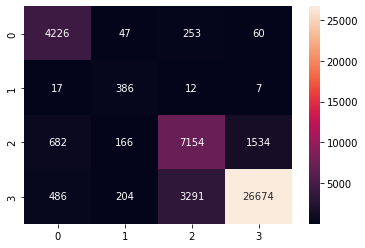

In [ ]:
pipe_lgbm = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',MinMaxScaler()),
                    ('model',LGBMClassifier())
                    ])

pipe_lgbm.fit(X_train, y_train)

y_pred = pipe_lgbm.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_lgbm.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.8504612933914467
ROC_AUC: 0.9738852342890612
F1 0.8547454447946051
Fbeta 0.7368416949123331


###ANN

In [ ]:
# Oversampling
smt = SMOTE(random_state=42)
X_train_transformed, y_train_transformed = smt.fit_resample(X_train, y_train)
X_test_transformed, y_test_transformed = smt.fit_resample(X_test, y_test)

# Normalization
scaler = StandardScaler()
X_train_transformed =  scaler.fit_transform(X_train_transformed)
X_test_transformed =  scaler.transform(X_test_transformed)

y_train_transformed = y_train_transformed -1
y_test_transformed = y_test_transformed -1

In [ ]:
model = tf.keras.Sequential([
          layers.Input(shape=(11,)),
          layers.Dense(512, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(16, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(4, activation='softmax')
          ])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train_transformed, epochs=20, validation_data=(X_test_transformed, y_test_transformed))

Epoch 1/20
13411/13411 [==============================] - 66s 5ms/step - loss: 0.4320 - accuracy: 0.8444 - val_loss: 0.3991 - val_accuracy: 0.8571
Epoch 2/20
13411/13411 [==============================] - 59s 4ms/step - loss: 0.3568 - accuracy: 0.8704 - val_loss: 0.4025 - val_accuracy: 0.8674
Epoch 3/20
13411/13411 [==============================] - 61s 5ms/step - loss: 0.3277 - accuracy: 0.8806 - val_loss: 0.4313 - val_accuracy: 0.8676
Epoch 4/20
13411/13411 [==============================] - 55s 4ms/step - loss: 0.3111 - accuracy: 0.8863 - val_loss: 0.4581 - val_accuracy: 0.8698
Epoch 5/20
13411/13411 [==============================] - 57s 4ms/step - loss: 0.3001 - accuracy: 0.8905 - val_loss: 0.4670 - val_accuracy: 0.8726
Epoch 6/20
13411/13411 [==============================] - 59s 4ms/step - loss: 0.2897 - accuracy: 0.8939 - val_loss: 0.4417 - val_accuracy: 0.8748
Epoch 7/20
13411/13411 [==============================] - 66s 5ms/step - loss: 0.2822 - accuracy: 0.8965 - val_loss: 0

In [ ]:
model = tf.keras.Sequential([
          layers.Input(shape=(11,)),
          layers.Dense(16, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          
          layers.Dropout(0.2),
          layers.Dense(4, activation='softmax')
          ])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train_transformed, epochs=20, validation_data=(X_test_transformed, y_test_transformed))

Epoch 1/20
15328/15328 [==============================] - 30s 2ms/step - loss: 0.4246 - accuracy: 0.8406 - val_loss: 0.3996 - val_accuracy: 0.8509
Epoch 2/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3683 - accuracy: 0.8612 - val_loss: 0.3834 - val_accuracy: 0.8617
Epoch 3/20
15328/15328 [==============================] - 30s 2ms/step - loss: 0.3511 - accuracy: 0.8669 - val_loss: 0.3817 - val_accuracy: 0.8645
Epoch 4/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3400 - accuracy: 0.8716 - val_loss: 0.3892 - val_accuracy: 0.8671
Epoch 5/20
15328/15328 [==============================] - 27s 2ms/step - loss: 0.3332 - accuracy: 0.8742 - val_loss: 0.3987 - val_accuracy: 0.8626
Epoch 6/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3267 - accuracy: 0.8767 - val_loss: 0.4058 - val_accuracy: 0.8651
Epoch 7/20
15328/15328 [==============================] - 27s 2ms/step - loss: 0.3226 - accuracy: 0.8783 - val_loss: 0

##Fine-tuning Best Model

In [ ]:
param_grid = [
    {'model__n_estimators': [2, 5, 10, 15, 20, 30, 40], 
     'model__max_features': [2, 4, 6, 8]}
  ]

pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])

cv=KFold(n_splits=5, random_state=42, shuffle=True)
rfc_gs = GridSearchCV(pipe_rfc, param_grid, cv=cv,
                           scoring='accuracy',
                           return_train_score=True, n_jobs=-1, verbose=2)

rfc_gs.fit(X_train, y_train)

rfc_result = pd.DataFrame(rfc_gs.cv_results_)
rfc_result = rfc_result.sort_values('rank_test_score')
for rec in rfc_result[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print('-'*10)
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean Accuracy:{rec[1]:.3f} +- {rec[2]:.3f}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 32.5min finished


----------
Rank 1
Params: {'model__max_features': 2, 'model__n_estimators': 40}
Mean Accuracy:0.903 +- 0.001
----------
Rank 2
Params: {'model__max_features': 4, 'model__n_estimators': 40}
Mean Accuracy:0.903 +- 0.001
----------
Rank 3
Params: {'model__max_features': 2, 'model__n_estimators': 30}
Mean Accuracy:0.902 +- 0.001
----------
Rank 4
Params: {'model__max_features': 6, 'model__n_estimators': 40}
Mean Accuracy:0.902 +- 0.000
----------
Rank 5
Params: {'model__max_features': 4, 'model__n_estimators': 30}
Mean Accuracy:0.902 +- 0.001


The highest Accuracy Random Forest Classifier model can achieve is 0.903. I will choose params (max_features:4, n_estimators:40) as the final model

##Final Cross-Validation on Test set

In [ ]:
best_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier(max_features=4, n_estimators=40))])
best_rfc.fit(X_train, y_train)

In [ ]:
# retrieve the best RF model
# best_rfc = rfc_gs.best_estimator_

# test the final model on Validation set
y_pred = best_rfc.predict(X_test)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# print(f"Random Forest Classifier {rfc_gs.best_params_}\n")
# Accuracy
final_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", final_acc)
# cross-validation Accuracy
cv_acc = cross_val_score(best_rfc, X_test, y_test, scoring= 'accuracy', cv=cv)
print("Cross-validation Accuracy:", np.mean(cv_acc))

# F1_weighted
final_f1 = f1_score(y_test, y_pred, average='weighted')
print("\nF1_weighted:", final_f1)
cv_f1 = cross_val_score(best_rfc, X_test, y_test, scoring= 'f1_weighted', cv=cv)
print("Cross-validation F1_weighted:", np.mean(cv_f1))

# Fbeta
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
final_fbeta = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
print('\nFbeta:', final_fbeta)
cv_fbeta = cross_val_score(best_rfc, X_test, y_test, scoring=fbeta, cv=cv)
print("Cross-validation Fbeta:", np.mean(cv_fbeta))

# ROC_AUC
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)
final_auc = roc_auc_score(y_test, best_rfc.predict_proba(X_test), multi_class='ovo')
print("\nROC_AUC", final_auc)
cv_auc = cross_val_score(best_rfc, X_test, y_test, scoring=roc_auc, cv=cv)
print("Cross-validation ROC_AUC:", np.mean(cv_auc))

Accuracy: 0.9079459772972077
Cross-validation Accuracy: 0.8780069315160102

F1_weighted: 0.9090280082846497
Cross-validation F1_weighted: 0.8806085867321498

Fbeta: 0.9099607315359025
Cross-validation Fbeta: 0.8808409973091177

ROC_AUC 0.9646569370966837
Cross-validation ROC_AUC: 0.9422813936116935


<Figure size 1152x432 with 0 Axes>

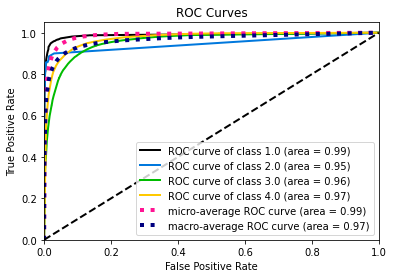

In [ ]:
!pip install scikit-plot

y_pred = best_rfc.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

##Error analysis

              precision    recall  f1-score   support

         1.0      0.895     0.914     0.904      3632
         2.0      0.355     0.786     0.489        70
         3.0      0.798     0.827     0.812      7977
         4.0      0.951     0.934     0.942     24528

    accuracy                          0.908     36207
   macro avg      0.750     0.865     0.787     36207
weighted avg      0.911     0.908     0.909     36207



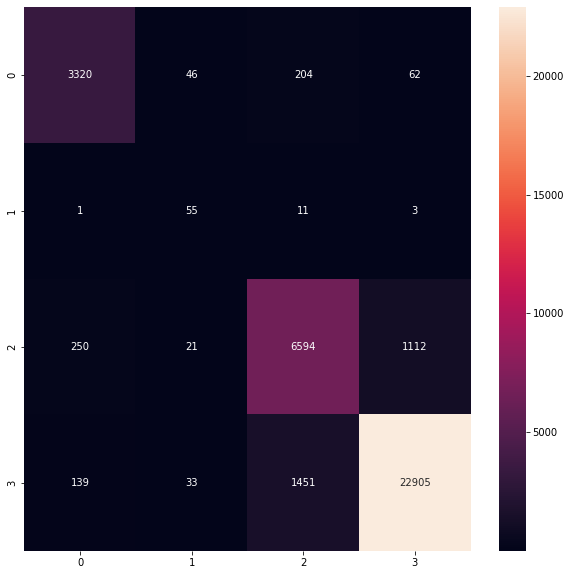

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data=confusion_matrix(y_test, best_rfc.predict(X_test)), annot=True,fmt = ".0f")
print(classification_report(y_test, best_rfc.predict(X_test), digits=3))

##Feature Importance

In [ ]:
feature_importances = best_rfc['model'].feature_importances_
sorted(zip(feature_importances, X_train.columns.values), reverse=True)

[(0.21653401507619702, 'Additives_count'),
 (0.1980431926696242, 'Sodium'),
 (0.14888290538742777, 'Energy_kcal'),
 (0.14413306461354555, 'Fat'),
 (0.06783588018689773, 'Carbohydrates'),
 (0.0624303786348369, 'Sugars'),
 (0.05081216300483267, 'Protein'),
 (0.04491366445022203, 'Saturated fat'),
 (0.0399314312339102, 'Fiber'),
 (0.02354183543392572, 'Cholesterol'),
 (0.0029414693085802433, 'Trans fat')]

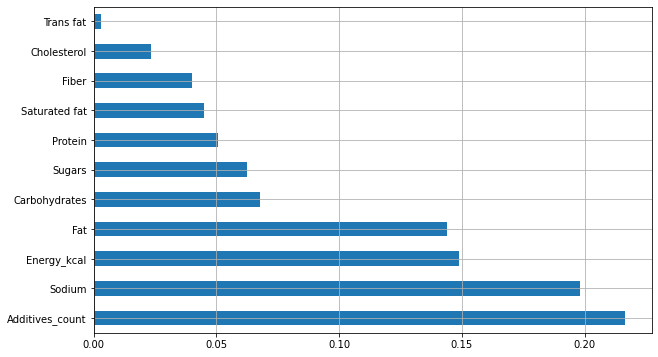

In [ ]:
feat_importances = pd.Series(feature_importances, index=X_train.columns)

plt.figure(figsize=(10,6))
feat_importances.nlargest(20).plot(kind='barh', grid=True)
# plt.savefig("feature_imp.jpg",dpi=300)
plt.show()

**Comment:** Apparently, **Additives** is the most important feature and **Trans fat** doesn't contribute much to the mean decrease in impurity of each tree

##Further Analysis

###Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA
pca_full = PCA() # keep all princial components 
pca_full.fit(X)

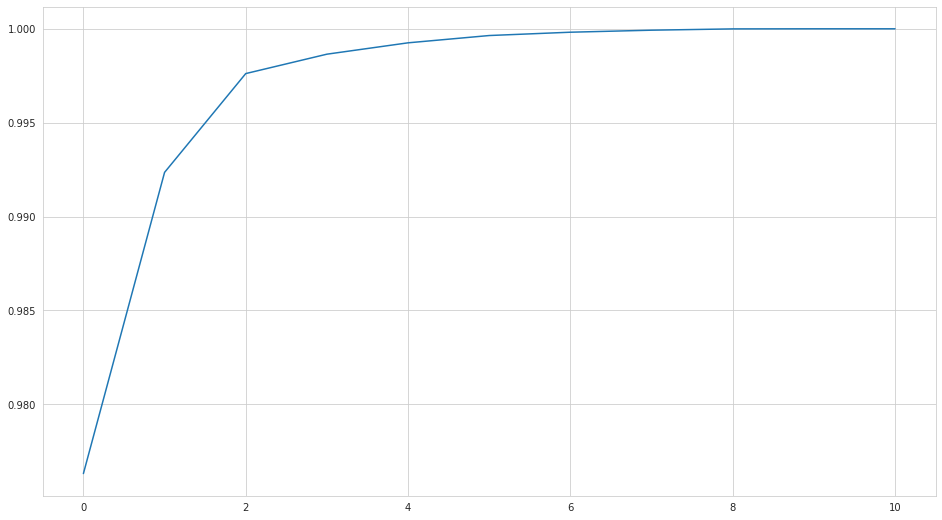

In [ ]:
sns.set_style('whitegrid')

plt.figure(figsize=(16, 9))
plt.plot(pca_full.explained_variance_ratio_.cumsum())

plt.show()

**Comment:** This plot shows that with just 2 PCA components can explain nearly 99.7% of the variance while 4 PCAs explain nearly 99.9% 

###KMeans Clustering

For further analysis I will keep 4 PCs to perform clustering to find some hidden pattern in the data

First, let's use elbow method to approximate the number of clusters

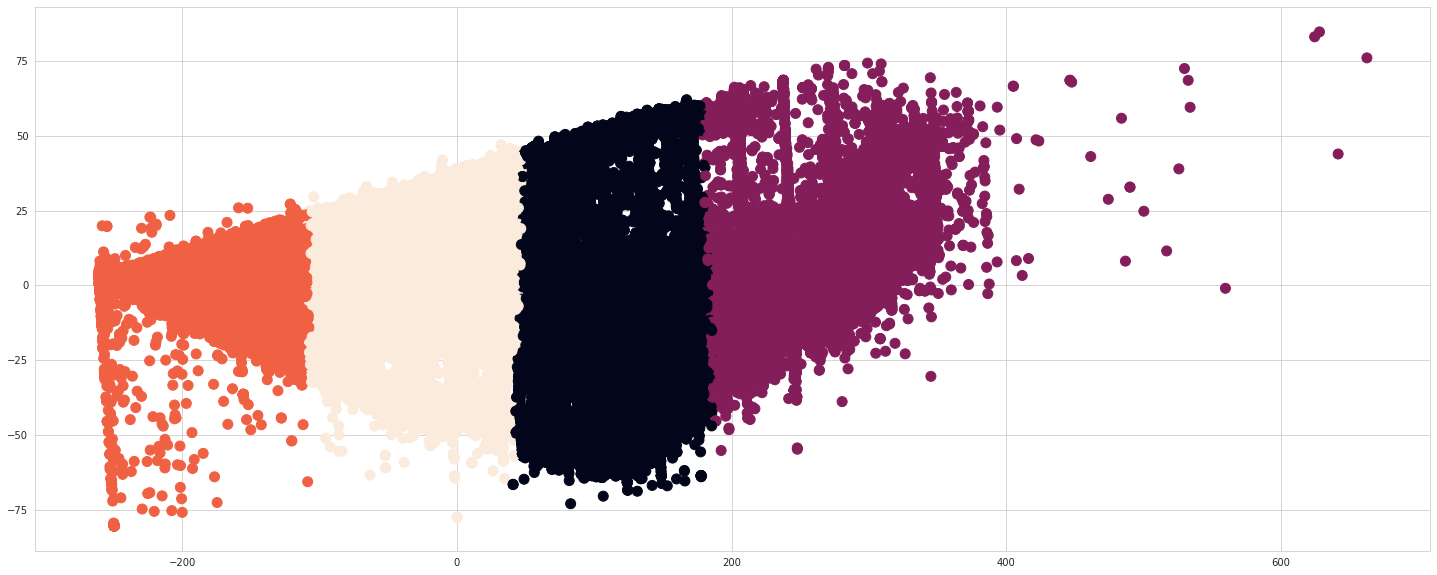

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)        
y_kmeans = kmeans.predict(X)

plt.figure(figsize=(25, 10))
plt.scatter(projected[:,0], projected[:,1], c=y_kmeans, s=100)

plt.show()

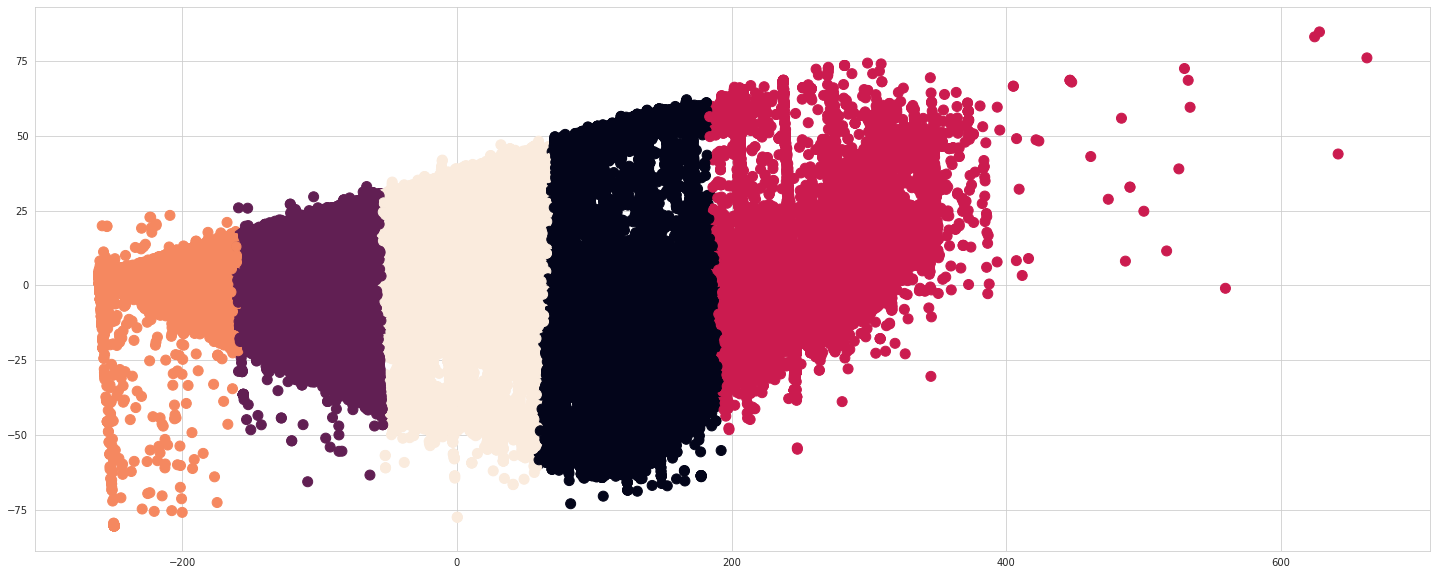

In [ ]:
from sklearn.cluster import KMeans
num_components=4
pca = PCA(n_components=num_components)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the model with the standardised data
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)
pcs = pca.components_ 

principalDf = pd.DataFrame(X_scaled_pca, columns = range(1,num_components+1))

from sklearn.cluster import KMeans
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 9
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(principalDf).score(principalDf) for i in range(len(kmeans_tests))]

In [ ]:
import plotly.express as px
fig = px.scatter(df_nova, x="Energy_kcal", y="Sugars", title="Energy/Sugars")
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = px.scatter(df[df["Category"]=="Meat"], x="Fat", y="Saturated fat", title="Energy/Sugars")
fig.show()

##Future deployment

In [ ]:
best_rfc.fit(X, y)

Pipeline(memory=None,
         steps=[('smt',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=4,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min

Save model

In [ ]:
# import joblib

# joblib.dump(best_rfc, "nova_rfc_11.pkl")

# !cp "/content/nova_rfc_11.pkl" "/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files"
# # and later...
best_rfc = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_rfc.pkl")